# Automating your experimentation with PyCaret


**DISCLAIMER**: This notebook does not intend to achieve a model with great results. 

**DISCLAIMER 2**: This was prepared using PyCaret 2.3.6, before that the OOP version was released.

The idea is to show how to automate experimentation and analysis using this great AutoML package, which compiles together awesome open source resources from multiple authors.

The package itself already automates a lot and it's great! We are just bringing experimentation into a more "*productionized*" layout.

We will go through a churn example from a dataset found in [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn).

First things first, let's take a look at the data :)

## A quick take on the data

Even though it's not our focus for today, looking at the data is always fun

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv('../data/dataset.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


From the 21 columns, we have a total of 19 features, since `Churn` is the target and `customerID` is a unique identifier. To better handle numerical, categorical, and target later on, we store them properly in the `config` directory.

In [3]:
import sys
sys.path.append('..')
from churn.config.features import Features

print('**Numerical**')
print(Features.NUMERICAL)
print('\n**Categorical**')
print(Features.CATEGORICAL)
print('\n**Not Features**')
print(Features.NOT_FEATURES)
print('\n**Target**')
print(Features.TARGET)

**Numerical**
('tenure', 'MonthlyCharges', 'TotalCharges')

**Categorical**
('gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod')

**Not Features**
('customerID',)

**Target**
Churn


Notice that, although `TotalCharges` is a numerical variable, it appears to be with the `object dtype`. Let's fix that to avoid problems ahead.

Since there are no explicit `NaNs`, we cannot use the pandas'  built-in `fillna`
We do have a few empty strings in this field preventing us 
from converting to float easily. We replace them by a number out of the 
distribution.

In [4]:
dataset[list(Features.NUMERICAL)] = dataset[list(Features.NUMERICAL)]\
                                        .replace(' ', -1).astype('float')

Let's check if there are other missing values as empty strings as well:

In [5]:
FEATURES = list(Features.CATEGORICAL) + list(Features.NUMERICAL)
for feat in FEATURES:
    print(feat, (dataset[feat] == ' ').sum(), dataset[feat].isna().sum())
    

gender 0 0
SeniorCitizen 0 0
Partner 0 0
Dependents 0 0
PhoneService 0 0
MultipleLines 0 0
InternetService 0 0
OnlineSecurity 0 0
OnlineBackup 0 0
DeviceProtection 0 0
TechSupport 0 0
StreamingTV 0 0
StreamingMovies 0 0
Contract 0 0
PaperlessBilling 0 0
PaymentMethod 0 0
tenure 0 0
MonthlyCharges 0 0
TotalCharges 0 0


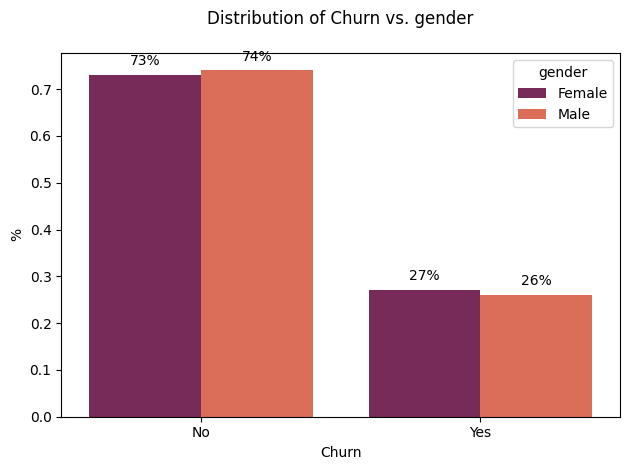

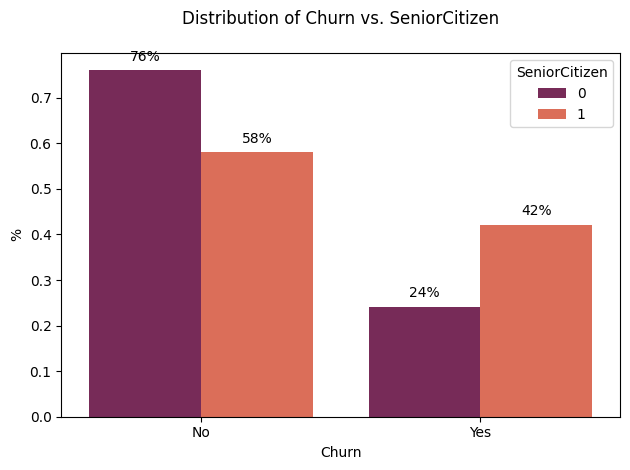

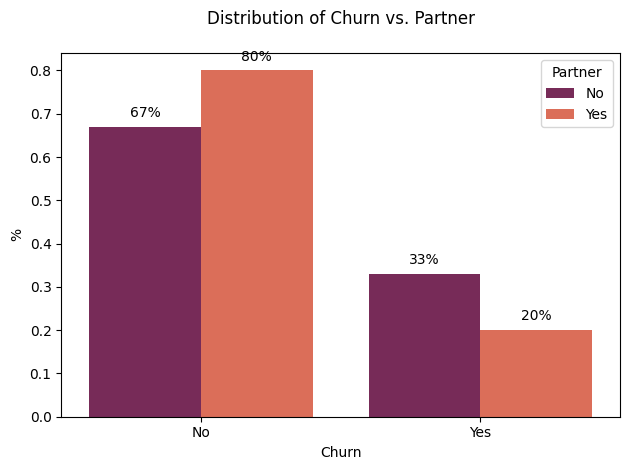

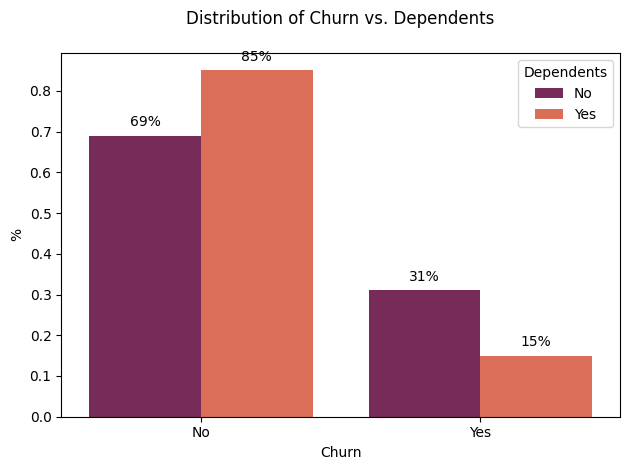

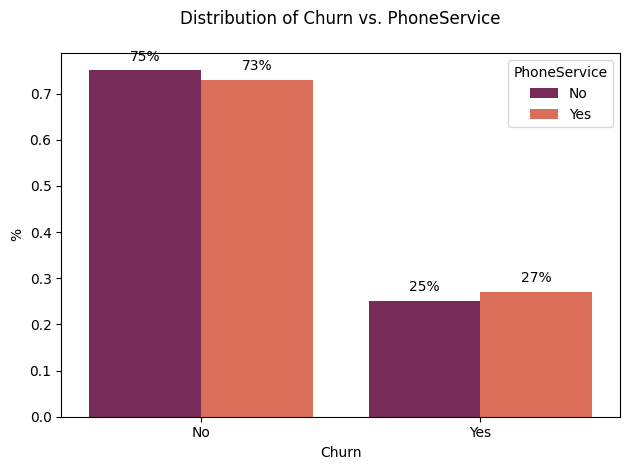

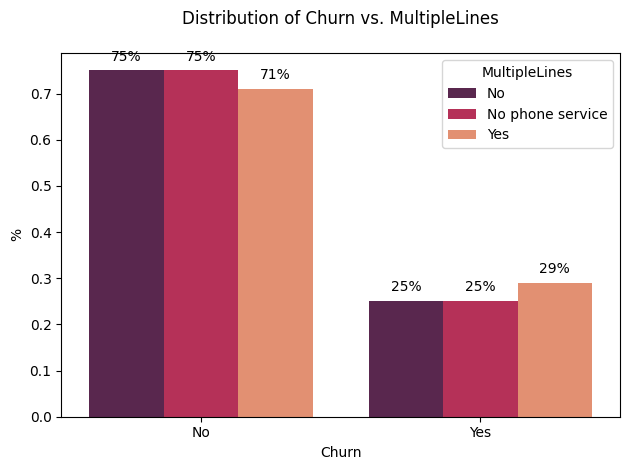

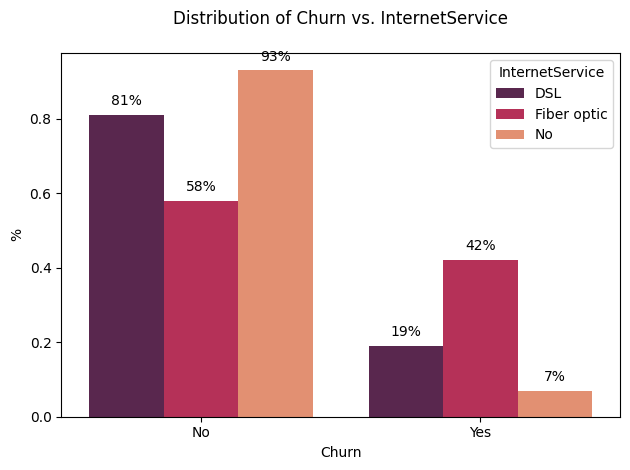

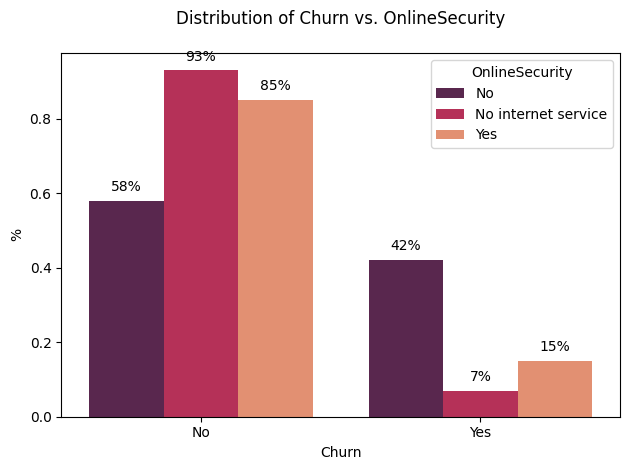

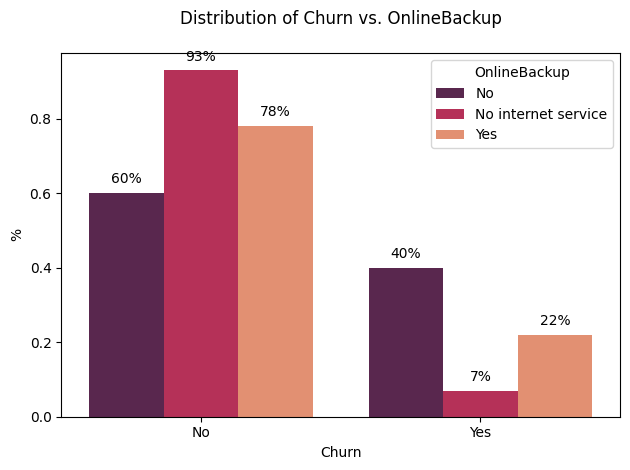

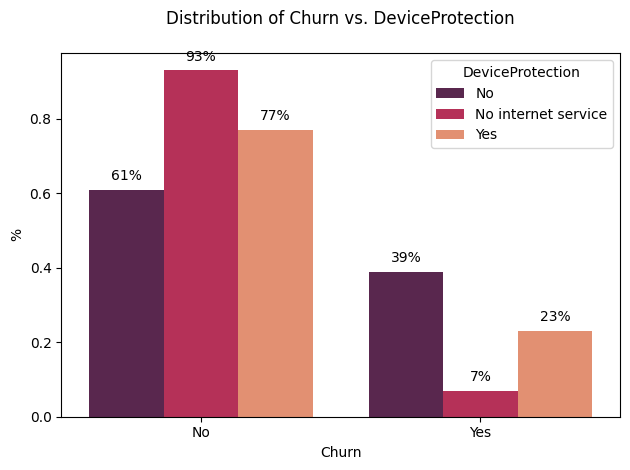

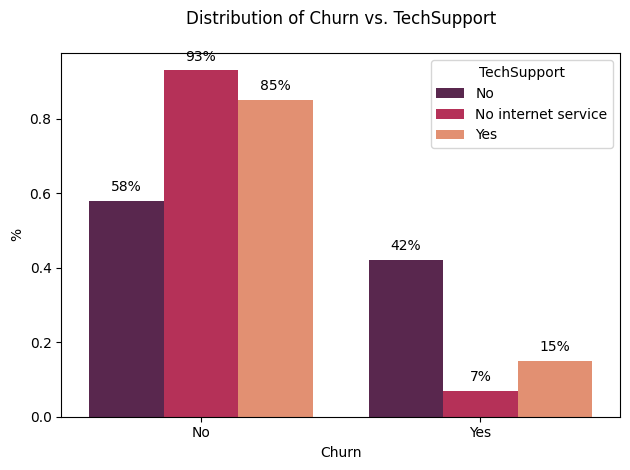

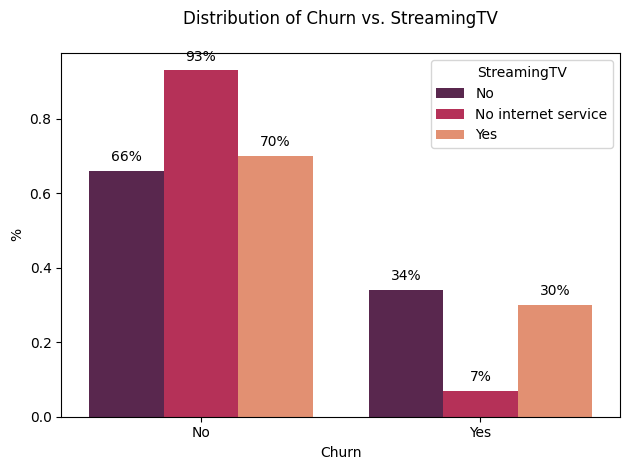

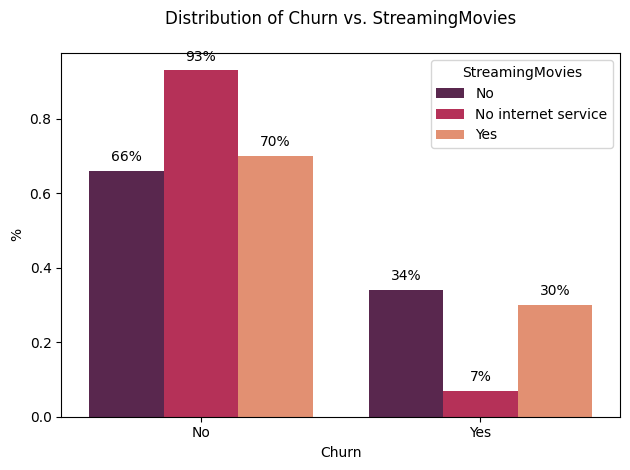

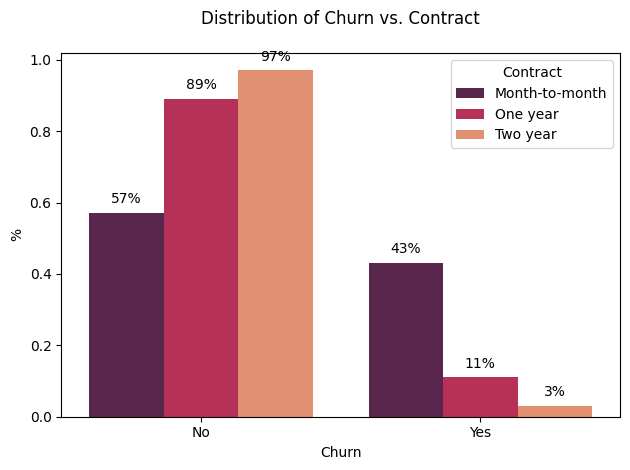

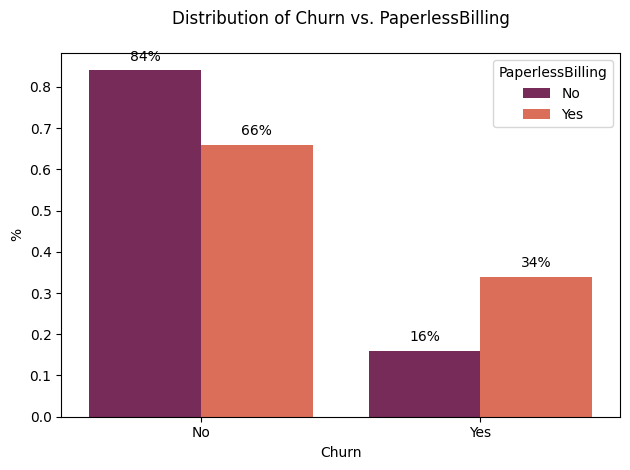

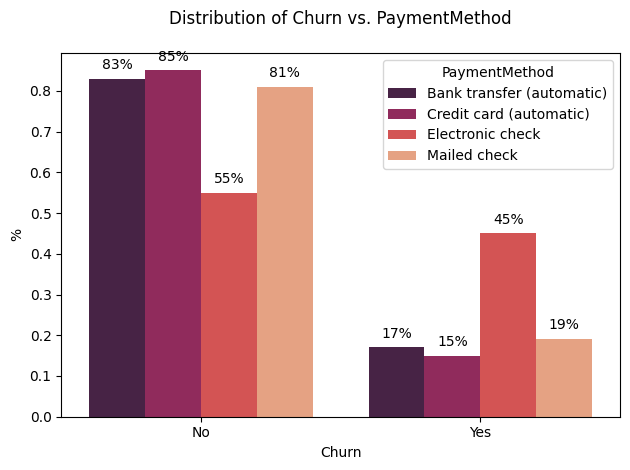

In [6]:
from churn.utils.plot import *
%matplotlib inline

for feat in Features.CATEGORICAL:
    plot_distribution_categorical_feature_by_categorical_target(
        feat=feat,
        target=Features.TARGET,
        df=dataset
    )

Insights:
* Gender plays no difference in churn
* Senior citizens are more likely to churn
* People without partner or dependents tend to churn less
* No significant difference in churn between those who use phone service or not
* People with multiple lines churn more often
* Fiver optic clients are the most unhappy ones.
* Clients with Internet but no online security tend to churn more
* Users who don't backup online churn more than those who do
* Clients with short-term contracts churn more often.
* Those who use electronic checks are much more likely to churn.


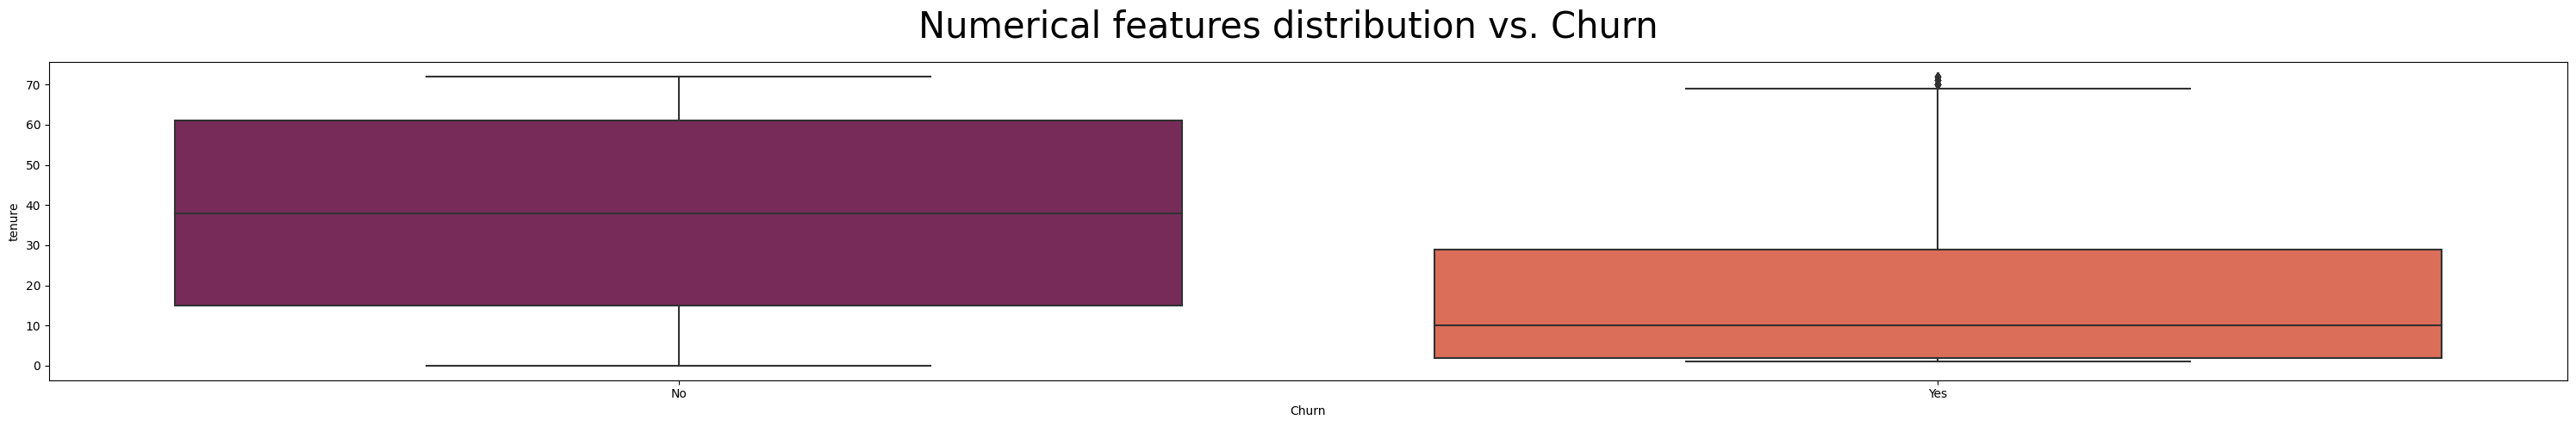

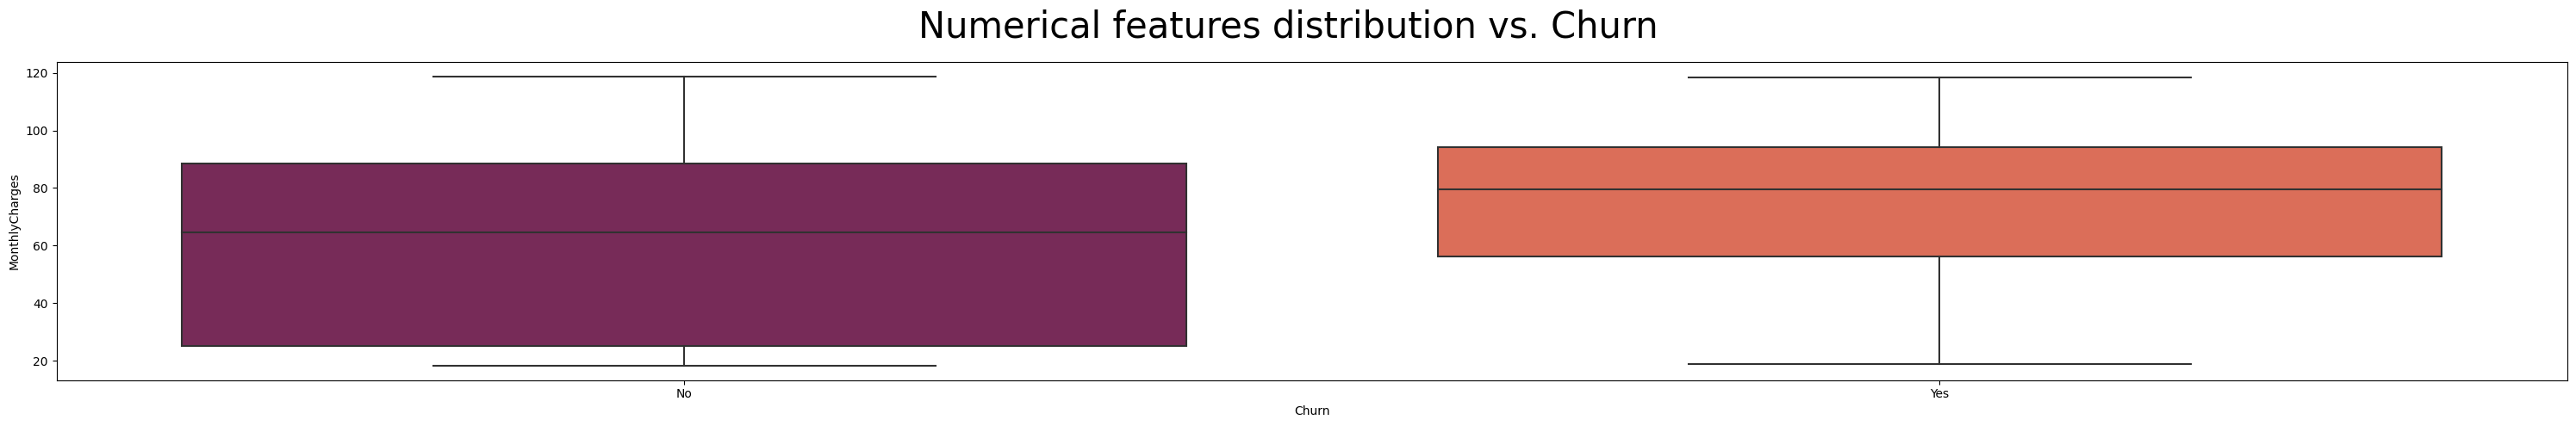

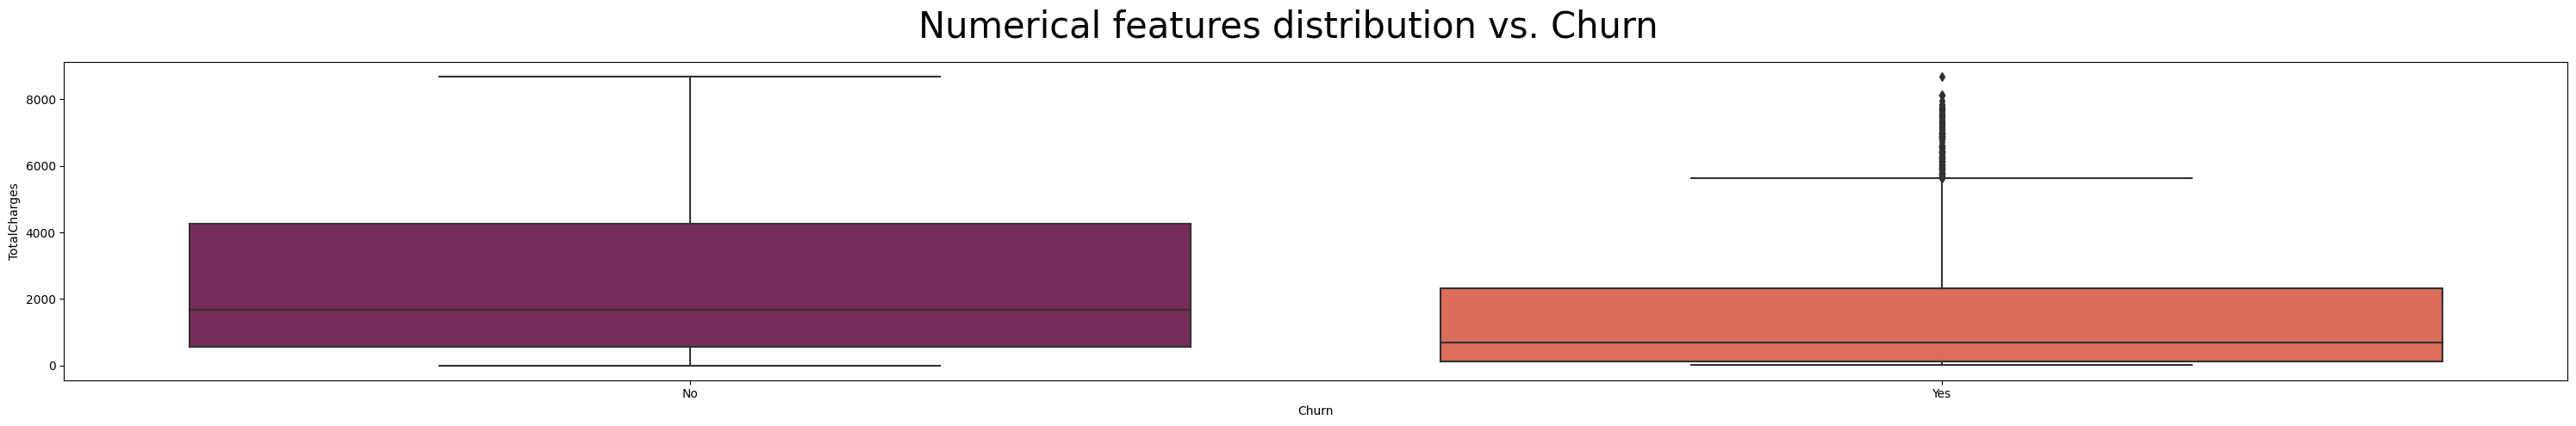

In [7]:
for feat in Features.NUMERICAL:
    plot_boxplot_numerical_by_target(
        numerical_features=[feat],
        target=Features.TARGET,
        df=dataset,
    )

Insights:
* Older customers are more loyal.
* Customers with higher monthly chargers are more likely to leave.
* Customer that don't consume much also are more likely to churn.

# Experiment: Having the first baseline model

Without any feature engineering, let's see if a few models can explain our dependent variable. If the results are poor, the first thing we have to do is to enhance our data.

Once we have a model that performs quite well to our standard, we may need to abandon the current framework and dive deeper into hyperparameter tuning of our best model. But let's not get ahead of ourselves here.

> OBS: We are running the experiment in a Jupyter Notebook, but bear in mind that the way the code was designed for it to be run in scripts, saving all the telemetry in log files.

In [8]:
from churn.utils.experiment import Experiment

exp = Experiment(data=dataset, experiment_name='churn_baseline')

We initialize the setup, i.e., how we wish to process the data. Here, it seems that we didn't choose anything, but please take a look at the [code](../churn/utils/experiment.py) to better understand what it's being done here.

Another important thing we do is that we split the dataset into three: `train`, `dev`, and `test`. While we are still experimenting with many possibilities of models and how to model the data itself, it is wise to set part of the data aside and only use it at the end, after we are satisfied with the model at hand. We, thus, use the test set to ensure our work i the train/dev generalized well enough. That is, that we can feed unseen data into the model and the results will be very close to the ones we saw in the dev set.

In [9]:
exp.initialize_train_setup(html=True)

logs - INFO - Logging experiment in MLFlow
logs - WARNING - Couldn't create mlflow experiment. Exception:
logs - WARNING - Traceback (most recent call last):
  File "/Users/leonardor/churn/.venv/lib/python3.8/site-packages/pycaret/internal/tabular.py", line 1742, in setup
    mlflow.create_experiment(exp_name_log)
  File "/Users/leonardor/churn/.venv/lib/python3.8/site-packages/mlflow/tracking/fluent.py", line 1214, in create_experiment
    return MlflowClient().create_experiment(name, artifact_location, tags)
  File "/Users/leonardor/churn/.venv/lib/python3.8/site-packages/mlflow/tracking/client.py", line 616, in create_experiment
    return self._tracking_client.create_experiment(name, artifact_location, tags)
  File "/Users/leonardor/churn/.venv/lib/python3.8/site-packages/mlflow/tracking/_tracking_service/client.py", line 240, in create_experiment
    return self.store.create_experiment(
  File "/Users/leonardor/churn/.venv/lib/python3.8/site-packages/mlflow/store/tracking/file_sto

logs - INFO - save_model() successfully completed......................................
logs - INFO - SubProcess save_model() end ==================================
logs - INFO - create_model_container: 0
logs - INFO - master_model_container: 0
logs - INFO - display_container: 1
logs - INFO - Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['gender',
                                                            'SeniorCitizen',
                                                            'Partner',
                                                            'Dependents',
                                                            'PhoneService',
                                                            'MultipleLines',
                                                            'InternetService',
                                                            'OnlineSecurity',
                                                       

We, now, can finally train a few models and choose the best to be our baseline model. We are considering `F1` as the main metric to make this decision.

In [10]:
exp.train_model(sort='F1')

Transformation Pipeline and Model Successfully Saved
{"cm_data": [[710, 66], [115, 165]]}


Considering that we have ~25% of churn in the dataset, I'd say that this initial baseline is not bat at all. 

Now that we have a first baseline, a good second step would be to analyze its performance by running an `ExplainerDashboard`! But be patient, because this may take around 20 min.

If, instead, you prefer to see the non-interactive dashboard, you can check it out at [notebooks/dashboard.html](./dashboard.html)

In [11]:
exp.analyze()

Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Building ExplainerDashboard..
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


  0%|          | 0/1056 [00:00<?, ?it/s]

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - self.fx = 0.5004689899036877
shap - DEBUG - self.link(self.fx) = 0.5004689899036877
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.0099361   0.         -0.00115263  0.00051967  0.          0.
  0.          0.          0.00044659 -0.00081569  0.00320971 -0.00207314
  0.00066872  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.00073992 -0.0048884
  0.00137689  0.          0.00072154  0.0003321   0.          0.00042121
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) =

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.001603101968471459
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0020350693632108507
shap - DEBUG - self.fx = 0.5129336853333025
shap - DEBUG - self.link(self.fx) = 0.5129336853333025
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00041468 -0.00095919  0.0005412   0.          0.
  0.          0.          0.         -0.00079262  0.0032017  -0.00209584
  0.00063759  0.00033576  0.          0.          0.          0.
  0.00091756  0.          0.00031242  0.         -0.00115333  0.00448061
 -0.00392702  0.         -0.00063368  0.00032326  0.          0.00043197
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0

shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00103695 -0.00037597  0.         -0.00048904  0.          0.
  0.          0.          0.          0.          0.00300775 -0.00172152
  0.00159272 -0.00030406  0.          0.          0.          0.
  0.          0.         -0.0003071   0.         -0.00066451  0.00489407
 -0.00131206  0.         -0.0006923  -0.0002901   0.00073767 -0.0004257
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2


shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.008574273772523747
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.00813879550355523
shap - DEBUG - self.fx = 0.5027598204665364
shap - DEBUG - self.link(self.fx) = 0.5027598204665364
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.510898615

shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.006508123710060288
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.008327511739956994
shap - DEBUG - self.fx = 0.4974288957698653
shap - DEBUG - self.link(self.fx) = 0.4974288957698653
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00038401 -0.00032756 -0.00051215  0.          0.
  0.          0.          0.          0.          0.00298929  0.00207892
 -0.00063156 -0.00032479  0.          0.          0.          0.
  0.          0.          0.00049632  0.         -0.00075218  0.00491331
 -0.00137075  0.          0.00065814 -0.00032485  0.          

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.005390650272253139
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.004941

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = 0.002990397361068952
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.002542576026031085
shap - DEBUG - self.fx = 0.4916439600559394
shap - DEBUG - self.link(self.fx) = 0.4916439600559394
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.          0.00038105 -0.00050639  0.          0.
  0.          0.         -0.00049121  0.00079293 -0.00323096 -0.00178302
  0.00156795  0.00037755  0.          0.          0.          0.
  0.          0.          0.          0.          0.00110914  0.00486259
 -0.00

shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0. 

shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.00087377  0.00042035  0.0009572  -0.00125411  0.          0.
  0.          0.          0.00043499 -0.0007713   0.00321273  0.00176222
 -0.00155487  0.          0.          0.          0.          0.
  0.00094867  0.         -0.000472    0.          0.00073354  0.00450241
  0.00137562  0.          0.0007062  -0.00063536  0.          0.00044204
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.011240044117792718
shap - DEBUG 

shap - INFO - phi = [ 0.         -0.00042516 -0.00034271 -0.00052696  0.          0.
  0.          0.         -0.00044822  0.0007816  -0.00321616 -0.00176193
  0.00156066 -0.00032858  0.          0.          0.          0.
 -0.00094166  0.         -0.00031286  0.         -0.00075012 -0.0044845
 -0.00136535  0.         -0.00073341  0.00062869 -0.00018344 -0.00044615
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsampl

shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.01874331406402912
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.018190928935263306
shap - DEBUG - self.fx = 0.49270768703482837
shap - DEBUG - self.link(self.fx) = 0.49270768703482837
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00988623  0.00044333 -0.00109187 -0.00121108  0.          0.
  0.          0.          0.00053127  0.         -0.00292268 -0.00205326
  0.0006956   0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.00077722 -0.00482611
  0.00139294  0.         -

shap - DEBUG - np.sum(w) = 0.009683096360052212
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0092455738398593
shap - DEBUG - self.fx = 0.4983469578697676
shap - DEBUG - self.link(self.fx) = 0.4983469578697676
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00737403 -0.00058596  0.00113213 -0.00050383  0.          0.
  0.00215196  0.         -0.00043932  0.00081033 -0.00319089  0.0020837
 -0.00064226  0.          0.          0.          0.          0.
  0.          0.         -0.00031727  0.         -0.00073287  0.00492208
 -0.00135733  0.         -0.00069753 -0.00032387  0.         -0.00043752
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - 

shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.010075369172354609
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.008217367216079574
shap - DEBUG - self.fx = 0.5191159831861712
shap - DEBUG - self.link(self.fx) =

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.005109316135323041
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.004622574294927295
shap - DEBUG - self.fx = 0.4937239583248356
shap - DEBUG - self.link(self.fx) = 0.4937239583248356
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00105039  0.00093203 -0.00056681  0.          0.
  0.          0.         -0.00049339  0.          0.00294102 -0.00180189
  0.00153164  0.00031237  0.          0.          0.          0.
 -0.000950

shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0. 

shap - INFO - phi = [-0.00308378  0.00047927 -0.00098295  0.00060469  0.          0.
  0.          0.         -0.00027545  0.         -0.00294002 -0.0020186
  0.00073096 -0.00030949  0.          0.          0.          0.
  0.          0.          0.          0.          0.00082633 -0.00480638
  0.00143067  0.         -0.00051935  0.          0.         -0.00171409
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.010864094565203434
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.01257818771946595
shap - DEBUG - self.fx = 0.5016795717493743
shap - DEBUG - self.link(self.fx) = 0.501679

shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_

shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.02063547  0.00021669  0.00076939  0.00044884  0.          0.
  0.          0.          0.00027262  0.          0.00305066  0.00159373
 -0.00171359  0.0002822   0.          0.          0.          0.
  0.00075241  0.          0.          0.          0.00060491  0.00426224
  0.00123245  0.          0.          0.          0.          0.00031438
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.03240802145444273
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.032722396901383344
shap - DEBUG - self.fx = 0.

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.02220044443691351
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.023897922645144454
shap - DEBUG - self.fx = 0.4870006933249472
shap - DEBUG - self.link(self.fx) = 0.4870006933249472
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.0098194   0.         -0.0010634  -0.00118975  0.          0.
  0.          0.         -0.00026906  0.         -0.00290637 -0.00198503
  0.00076796 -0.00024522  0.          0.          0.          0.
 -0.00018084  0.         -0.00038382  0.         -0.00103347 -0.00479146
  0.00147144  0.         -0.00057204  0.          0.         -0.00169748
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00990176  0.00144946  0.0032133  -0.00052836  0.          0.
  0.          0.         -0.00044819 -0.00023565 -0.00322813 -0.00178741
 -0.00069074 -0.00033617  0.          0.          0.          0.
  0.          0.          0.          0.         -0.00073737  0.00483133
 -0.00137891  0.         -0.00073654 -0.00036675  0.00066223 -0.00044891
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8

shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.013053385240263045
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.013440677944470347
shap - DEBUG - self.fx = 0.524339293914562
shap - DEBUG - self.link(self.fx) = 0.524339293914562
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00055945  0.          0.00046518  0.          0.
  0.          0.          0.00042022  0.00021353  0.00319835  0.00171585
  0.0005903   0.00028232  0.          0.    

shap - DEBUG - np.sum(w) = -0.007503978956891326
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.007949449837109879
shap - DEBUG - self.fx = 0.48115193419279845
shap - DEBUG - self.link(self.fx) = 0.48115193419279845
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00083654  0.          0.00096754 -0.00053834  0.          0.
  0.00213383  0.         -0.00044922  0.0007741  -0.00320748  0.00206944
 -0.00065704 -0.0003323   0.          0.          0.          0.
 -0.00092525  0.          0.00046963  0.         -0.00073794 -0.00449583
 -0.00136627  0.         -0.00072534 -0.00033886  0.00069188 -0.00044547
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15


shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.007346225894009719
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.00915971210984734
shap - DEBUG - self.fx = 0.5017389038602443
shap - DEBUG - self.link(self.fx) = 0.5017389038602443
shap - DEBUG 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.008036450366691308
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.00845750131749129
shap - DEBUG - self.fx = 0.48064388271241704
shap - DEBUG - self.link(self.fx) = 0.48064388271241704
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00039692 -0.00092606 -0.00050527  0.          0.
  0.          0.          0.          0.00080095 -0.0032074  -0.00175721
  0.00158578  0.00036629  0.          0. 

shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self

shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00045274 -0.00089599  0.00055424  0.          0.
  0.          0.         -0.00029432  0.         -0.00294388 -0.00202018
  0.00062935  0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.00107846 -0.00483598
  0.00139207  0.         -0.00060397  0.          0.         -0.00175424
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.009644366108460518
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.01139860955979255
shap - DEBUG 

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.010758553993050134
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.01020750427376882
shap - DEBUG - self.fx = 0.5006911116963229
shap - DEBUG - self.link(self.fx) = 0.5006911116963229
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.         -0.00090111 -0.0011582   0.          0.
  0.          0.         -0.00026359  0.         -0.00290153  0.00185679
 -0.00145767 -0.00026075  0.          0.          0.          0.
 -0.00017203  0.          0.          0.         -0.00102163 -0.00477112
  0.00149705  0.         -0.00054946  0.         -0.00065531  0.00055105
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.008041263927262454
shap - DEBUG - self.fx = 0.5028573520428292
shap - DEBUG - self.link(self.fx) = 0.5028573520428292
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00089216  0.         -0.00032782 -0.00115185  0.          0.
  0.          0.          0.0005485   0.         -0.00287772 -0.00195273
  0.00074729 -0.00026028  0.          0.          0.          0.
 -0.00017916  0.         -0.00041688  0.         -0.00098273  0.00459588
 -0.00383341  0.         -0.00052952 -0.00052868  0.          0.
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  

shap - DEBUG - self.link(self.fx) = 0.4812585656630529
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00734734 -0.00060859  0.00114278 -0.00053076  0.          0.
  0.          0.         -0.0004372  -0.00022193 -0.00321102 -0.0017575
 -0.00065319 -0.0003273   0.          0.          0.          0.
  0.          0.         -0.00032677  0.         -0.00074998 -0.0044836
 -0.001368    0.         -0.00070896 -0.00033082 -0.00018953 -0.00042777
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - se

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0070262845244455025
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.00883600502275117
shap - DEBUG - self.fx = 0.5020626109473405
shap - DEBUG - self.link(self.fx) = 0.5020626109473405
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00038696 -0.00095709  0.00051704  0.          0.
  0.          0.          0.          0.         -0.00298581 -0.0021059
  0.00066222  0.00034774  0.  

shap - DEBUG - np.sum(w) = -0.002856149990953721
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0032420900418559384
shap - DEBUG - self.fx = 0.4858592939880524
shap - DEBUG - self.link(self.fx) = 0.4858592939880524
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.          0.00109528 -0.0004912   0.          0.
  0.00216404  0.         -0.00043439  0.00081672 -0.00317024 -0.00173021
  0.00156581  0.          0.          0.          0.          0.
 -0.00091385  0.         -0.00026069  0.         -0.00071709 -0.00445711
  0.00395583  0.         -0.00072388 -0.00029009  0.00073491 -0.00038594
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
s

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.012416340029482732
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.01279917

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0132940856479629
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.013690501711522807
shap - DEBUG - self.fx = 0.4754108823183855
shap - DEBUG - self.link(self.fx) = 0.4754108823183855
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00150959  0.         -0.00050304  0.          0.
  0.          0.         -0.00040433 -0.00018586 -0.00315365 -0.00171837
 -0.00062402 -0.00030597  0.          0.          0.          0.
  0.      

shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_

shap - DEBUG - self.fx = 0.49943057756083503
shap - DEBUG - self.link(self.fx) = 0.49943057756083503
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00734601  0.         -0.00110874  0.00052991  0.          0.
  0.          0.          0.00047982 -0.00076571  0.00321847 -0.0020652
  0.00067898  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.00075599 -0.00485978
  0.00137807  0.         -0.00061133  0.          0.         -0.00175252
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) 

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = 0.0005842994978575513
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0009941661938956958
shap - DEBUG - self.fx = 0.5118927821639874
shap - DEBUG - self.link(self.fx) = 0.5118927821639874
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.          0.          0.00050937  0.          0.
  0.          0.          0.00041736 -0.00083845  0.00317319  0.00171305
 -0.00158523  0.00028174  0.          0.          0.          0.
  0.          0.          0.00

shap - DEBUG - np.sum(w) = -0.0022537181134212516
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.00039367241023124944
shap - DEBUG - self.fx = 0.4887077116196771
shap - DEBUG - self.link(self.fx) = 0.4887077116196771
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00320546 -0.00058961  0.         -0.00049564  0.          0.
  0.          0.          0.         -0.0002002  -0.00316246 -0.00172513
 -0.00063699 -0.00029752  0.          0.          0.          0.
  0.          0.         -0.00028428  0.         -0.00066818  0.00493093
 -0.00134371  0.         -0.00067678 -0.00030959  0.          0.00186005
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0038024152099882043
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.00556621863727691
shap - DEBUG - self.fx

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.014559942125094472
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.014886098976906903
shap - DEBUG - self.fx = 0.4742152850530014
shap - DEBUG - self.link(self.fx) = 0.4742152850530014
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00057457  0.         -0.00048366  0.          0.
  0.          0.          0.         -0.00016935 -0.00310453 -0.00167869
 -0.00059432 -0.00026866  0.          0.          0.          0.
  0.          0.       

shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_

shap - DEBUG - np.sum(w) = 0.007699753991450742
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.008125934471874485
shap - DEBUG - self.fx = 0.5190245504419662
shap - DEBUG - self.link(self.fx) = 0.5190245504419662
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00054948  0.          0.00049946  0.          0.
  0.          0.          0.00044737  0.00019698  0.00318681  0.00176847
  0.00062515  0.00029184  0.          0.          0.          0.
  0.          0.          0.00029372  0.          0.00069386  0.00446429
 -0.00396134  0.         -0.00068435 -0.00067196  0.          0.00042618
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000004
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00731373  0.          0.0011026  -0.00058667  0.          0.
  0.00212682  0.         -0.00051979  0.00071503 -0.00323342  0.00205328
 -0.00068338  0.00033429  0.          0.          0.          0.
  0.          0.          0.          0.          0.00109991  0.00482618
 -0.00140928  0.          0.00061333  0.          0.          0.00176207
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2

shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.007321137605602579
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.009033676119129308
shap - DEBUG - self.fx = 0.5018649398509624
shap - DEBUG - self.link(self.fx) = 0.5018649398509624
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00089402  0.00047527 -0.00034688  0.00061358  0.          0.
  0.          0.          0.00050561  0.         -0.00286864 -0.00204285
  0.00073979  0.          0.          0.          0.          0.
  0.          0.         -0.00040985  0.          0.0008205  -0.00482658
  0.0014531   0.         

shap - DEBUG - np.sum(w) = -0.008122189621929787
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.008543182381592629
shap - DEBUG - self.fx = 0.4805582016483157
shap - DEBUG - self.link(self.fx) = 0.4805582016483157
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00082414 -0.00038746 -0.00095329  0.0012761   0.          0.
  0.          0.         -0.00044087  0.00078835 -0.00321275 -0.0017317
  0.00157747  0.          0.          0.          0.          0.
 -0.00093883  0.          0.00047693  0.          0.0011309  -0.00449886
 -0.0013623   0.          0.00064085 -0.00034823  0.00068563 -0.00042099
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
sha

shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0024055973900552795
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0019483183181056019
shap - DEBUG - self.fx = 0.5089502976519861
s

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0020219532895075667
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0016102270088097503
shap - DEBUG - self.fx = 0.4907116110387181
shap - DEBUG - self.link(self.fx) = 0.4907116110387181
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00036281  0.         -0.00050006  0.          0.
  0.          0.          0.         -0.00019744  0.00300557  0.00211268
 -0.00066438 -0.00031348  0.          0.          0.          0.
 -0.00091875  0.        

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [

shap - INFO - phi = [ 0.00269094  0.00040181  0.00095028  0.00053013  0.          0.
  0.          0.          0.          0.         -0.00301747 -0.00207567
  0.00066302  0.00030615  0.          0.          0.          0.
  0.          0.          0.00029872  0.          0.00072766  0.00445401
 -0.00392094  0.         -0.00063334  0.0003508  -0.00068654  0.00040982
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0010395700811375
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0014493933341842014
shap - DEBUG - self.fx = 0.4876519906957241
shap - D

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.012057043058500609
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.013787646411410559
shap - DEBUG - self.fx = 0.4971109695586811
shap - DEBUG - self.link(self.fx) = 0.4971109695586811
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00091344 -0.00101366 -0.00084863  0.00064053  0.          0.
  0.          0.         -0.00026707  0.         -0.00291554 -0.00202313
  0.0007122   0.          0.          0.          0.          0.
  0.          0.         -0.00040828  0.         -0.00103028 -0.00486337
  0.00143057  0.         -0.00055693  0.          0.         -0.0017306
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - INFO - phi = [ 0.          0.00110237 -0.00252259 -0.00044643  0.          0.
  0.          0.          0.          0.          0.00299674 -0.00170725
  0.00159418  0.          0.          0.          0.          0.
  0.          0.          0.00053266  0.          0.00114578 -0.00442194
 -0.00134183  0.          0.00066031  0.          0.00074563 -0.00046795
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamp

shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0020623317586368067
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0016801980850762455
shap - DEBUG - self.fx = 0.5092184178850154
shap - DEBUG - self.link(self.fx) = 0.5092184178850154
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.0003674   0.00092581  0.00047426  0.          0.
  0.          0.          0.          0.00020343 -0.00300146  0.00175333
 -0.00159776  0.00027637  0.          

shap - DEBUG - np.sum(w) = 0.0077934183495708955
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.009476390410299351
shap - DEBUG - self.fx = 0.4985777744402077
shap - DEBUG - self.link(self.fx) = 0.4985777744402077
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00101999 -0.00102557 -0.00057862  0.          0.
  0.          0.          0.00026949  0.          0.00289659 -0.00179129
  0.00148186  0.          0.          0.          0.          0.
  0.00020132  0.          0.00041194  0.          0.00104826  0.00482404
 -0.00147178  0.          0.00050718  0.          0.          0.00168297
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
sha

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0024318702766648924
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.002817717202485248
shap - DEBUG - self.f

shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0032373294127876835
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.002891423225793055
shap - DEBUG - self.fx = 0.4919928072557014
shap - DEBUG - self.link(self.fx) = 0.4919928072557014
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00322051  0.          0.         -0.00048744  0.          0.
  0.          0.         -0.00038719  0.00085164 -0.00316049  0.00215937
 -0.00057768  0.          0.          0.          0.          0.
  0.          0.         -0.00028054  0.         -0.00069787  0.00493049
 -0.00132914  0.         -0

shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0

shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.          0.00093658  0.00049733  0.          0.
  0.          0.          0.00042266 -0.00080302  0.00320916  0.00174442
 -0.00158271  0.          0.          0.          0.          0.
  0.00092378  0.          0.00029935  0.          0.00069586  0.00447483
 -0.00394869  0.          0.00069232 -0.00065775  0.          0.00039627
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = -0.006904133542566901
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.007300405730322368
shap - DEBUG - self.fx = 0.48180097829958596
shap -

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.006644595458974917
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.00840797559319606
shap - DEBUG - self.fx = 0.5024906403768956
shap - DEBUG - self.link(self.fx) = 0.5024906403768956
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.         -0.0003354   0.00057099  0.          0.
 -0.00207485  0.          0.         -0.00072496  0.00327246 -0.00204441
  0.00067671 -0.00029639  0.          0.          0.          0.
 -0.00021385  0.         -0.00041098  0.         -0.00108465 -0.00483068
  0.00145451  0.         -0.00060309  0.          0.         -0.00176338
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.000695730526186588
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0002609563110955726
shap - DEBUG - self.fx = 0.5106376596589961
shap - DEBUG - self.link(self.fx) = 0.5106376596589961
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.0031671  -0.00145174 -0.00114177  0.00054084  0.          0.
  0.          0.          0.00045201  0.00022868  0.00321835  0.0017812
  0.00064559  0.00033718  0.          0.          0.          0.
  0.          0.          0.0003202   0.          0.0007364  -0.00490064
  0.00135591  0.          0.00070656  0.00033516 -0.000692

shap - DEBUG - np.sum(w) = 0.00834162079434084
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.010057912615891063
shap - DEBUG - self.fx = 0.4991592966457994
shap - DEBUG - self.link(self.fx) = 0.4991592966457994
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00094838  0.00105379 -0.00105128 -0.00061576  0.          0.
  0.          0.          0.00026008  0.          0.00292796  0.0019932
 -0.00072875  0.          0.          0.          0.          0.
  0.          0.          0.00038723  0.          0.00106381  0.00482317
 -0.00142532  0.          0.00060189  0.          0.          0.00171629
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap -

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.014572153480667094
shap - DEBUG - self.link(self.fx) - self.link(self.fnull

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.024813929162422043
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.025219823426073373
shap - DEBUG - self.fx = 0.46388156060383495
shap - DEBUG - self.link(self.fx) = 0.46388156060383495
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.02074079 -0.00040802 -0.00092004  0.0013043   0.          0.
  0.          0.          0.          0.          0.00298667 -0.00171606
  0.00158664  0.          0.          0.          0.          0.
  0.          0.         -0.00028421  

shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.01362236685327924
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.01400408217963589
shap - DEBUG - self.fx = 0.47509730185027244
shap - DEBUG - self.link(self.fx) = 0.47509730185027244
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00051111  0.         -0.00049993  0.          0.
  0.          0.          0.         -0.00019293 -0.00311369 -0.00171002
 -0.00055809 -0.00031387  0.          0.          0.          0.
  0.          0.         -0.0002227   

shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.

shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.00269671 -0.00111887  0.00555629  0.00053599  0.          0.
  0.          0.          0.          0.         -0.00297672  0.00175611
 -0.00153988  0.00031392  0.          0.          0.          0.
  0.00096307  0.         -0.00048113  0.         -0.00111648  0.00452046
  0.00136429  0.         -0.00063163  0.0003653  -0.00068962  0.00045368
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0095178432077576
shap - DEBUG - 

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.007567927225506724
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.009308629121071887
shap - DEBUG - self.fx = 0.5015899868490198
shap - DEBUG - self.link(self.fx) = 0.5015899868490198
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.0009347   0.00044633 -0.00035051  0.00055443  0.          0.
  0.          0.         -0.00031762  0.         -0.00295201 -0.00203833
  0.00068716 -0.00031901  0.          0.          0.          0.
  0.00097564  0.         -0.00042521  0.          0.00077777 -0.00484759
  0.001389    0.         -0.00059573  0.00038247  0.         -0.0017407
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - self.link(self.fx) = 0.4772592923920396
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.02080486  0.00111341  0.00907559 -0.00053164  0.          0.
  0.          0.          0.          0.          0.00296169  0.0020528
 -0.00067085 -0.00035234  0.          0.          0.          0.
 -0.00093165  0.          0.00046803  0.          0.00111863 -0.0044962
 -0.00137712  0.          0.00065237 -0.00036562  0.00069411 -0.00044844
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - se

shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.007060005694057275
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.006634489533890786
shap - DEBUG - self.fx = 0.5042641264362009
shap - DEBUG - self.link(self.fx) = 0.5042641264362009
shap - DEBUG - self.fnull = 0.5108986159700917
sh

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.028566563005701654
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.02899415710361808
shap - DEBUG - self.fx = 0.46010722692629025
shap - DEBUG - self.link(self.fx) = 0.46010722692629025
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.02078939  0.          0.00097037 -0.00050779  0.          0.
  0.00214732  0.         -0.00043404  0.00078569 -0.0032061  -0.00172754
  0.0015785  -0.00030552  0.          0.          0.  

shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_

shap - DEBUG - self.fx = 0.5189101147560706
shap - DEBUG - self.link(self.fx) = 0.5189101147560706
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00055279 -0.00109992  0.00048695  0.          0.
  0.          0.          0.          0.00021184  0.00317828  0.00173447
  0.00061805  0.0003078   0.          0.          0.          0.
  0.          0.          0.00028344  0.          0.00072396  0.00446452
 -0.00391658  0.          0.00071296 -0.00066419  0.          0.00041712
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DE

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.007925770175618489
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.008334811895732819
shap - DEBUG - self.fx = 0.5192334278658245
shap - DEBUG - self.link(self.fx) = 0.5192334278658245
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00100726  0.00058411  0.          0.00048727  0.          0.
  0.          0.          0.00043556  0.00018136  0.00322644  0.00171928
  0.00065206  0.00030703  0.          0.          0.          0.
  0.          0.          0.00028653  0.          0.00071232  0.00445922
 -0.00394923  0.         -0.00066842  0.00032666  0.00017284  0.00040904
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.033282825538389516
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.03365507086805708
shap - DEBUG - self.fx = 0.5445536868381488
shap - DEBUG - self.link(self.fx) = 0.5445536868381488
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.02068303 -0.00153478  0.          0.00048501  0.          0.
  0.          0.          0.00039044  0.00012849  0.00313048  0.00172209
  0.0005935   0.00025154  0.          0.          0.          0.
  0.          0.          0.00025606  0.          0.00067179  0.00442118
  0.00127012  0.          0.00064846  0.          0.00016542  0.00037225
  0.        ]
shap -

shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.00044450065331663735
shap - DEBUG - self.fx = 0.48954588468322496
shap - DEBUG - self.link(self.fx) = 0.48954588468322496
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00044059 -0.00101781 -0.00052638  0.          0.
  0.          0.          0.          0.          0.00290147 -0.00177386
  0.00151976  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.0010765  -0.00452995
  0.00390209  0.         -0.00075721  0.00058638  0.         -0.0004959
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size 

shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = -0.001533038990139707
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.001

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.007452324763069486
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.00924208962218237
shap - DEBUG - self.fx = 0.4983434736520907
shap - DEBUG - self.link(self.fx) = 0.4983434736520907
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00310904 -0.0004712   0.00103402 -0.00055559  0.          0.
  0.          0.         -0.00051272  0.0007377  -0.00325577  0.00203828
 -0.00071911  0.00030644  0.          0.          0.       

shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - D

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0012420007267763815
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0030713056058204735
shap - DEBUG - self.fx = 0.4921726896357288
shap - DEBUG - self.link(self.fx) = 0.4921726896357288
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00094759 -0.00043806  0.00040044 -0.00052287  0.          0.
  0.          0.          0.          0.          0.00297401  0.00208686
 -0.00063713  0.          0.          0.          0.          0.
 -0.00094745  0.        

shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_

shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.005728411040327397
shap - DEBUG - self.fx = 0.5166270270104191
shap - DEBUG - self.link(self.fx) = 0.5166270270104191
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.         -0.00148783  0.         -0.00130154  0.          0.
  0.          0.          0.0003988   0.00020478  0.00316821  0.00173252
  0.00060725  0.00031205  0.          0.          0.          0.
  0.          0.          0.00028485  0.          0.00070235  0.00444019
 -0.00396603  0.          0.00067978  0.00028912 -0.00075033  0.00041425
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  

shap - INFO - phi = [ 0.00091954 -0.00043203  0.00032817  0.00122912  0.          0.
  0.          0.          0.0002945   0.          0.00295943  0.00203447
 -0.00074551  0.00031968  0.          0.          0.          0.
  0.          0.          0.00041358  0.         -0.00078033  0.00486347
 -0.00138566  0.         -0.00078659  0.          0.          0.00172879
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamp

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.01398997676180483
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.014379744005072803
shap - DEBUG - self.fx = 0.5252783599751645
shap - DEBUG - self.link(self.fx) = 0.5252783599751645
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00055269  0.          0.00049386  0.          0.
  0.          0.          0.00040933  0.000175    0.00317961  0.00170312
  0.00063415  0.00031871  0.          0.          0.          0.
  0.       

shap - DEBUG - np.sum(w) = 0.01206668176818602
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.013820193892374322
shap - DEBUG - self.fx = 0.5029215779222826
shap - DEBUG - self.link(self.fx) = 0.5029215779222826
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.0030626   0.          0.00099622  0.00119382  0.          0.
  0.00208695  0.          0.          0.00070336 -0.00326323  0.0020495
 -0.00072554  0.00027803  0.          0.          0.          0.
  0.00021425  0.          0.00040481  0.          0.00109241  0.00482197
 -0.00142237  0.          0.00057389  0.          0.          0.00175351
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap -

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.010556150680864804
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.010165266305603549
shap - DEBUG - self.fx = 0.5007333496644881
shap - DEBUG - self.link(self.fx) = 0.5007333496644881
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00995958  0.         -0.00117315  0.00050228  0.          0.
  0.          0.          0.00043747 -0.00083013  0.003161    0.00177659
 -0.00159137 

shap - DEBUG - np.sum(w) = 0.0024599536459670684
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0020294721415444195
shap - DEBUG - self.fx = 0.49113085617145275
shap - DEBUG - self.link(self.fx) = 0.49113085617145275
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00041544 -0.00032839  0.00127093  0.          0.
  0.          0.          0.          0.00075937 -0.00319444 -0.00173588
  0.00154923  0.          0.          0.          0.          0.
  0.          0.          0.00046702  0.         -0.00067937  0.00487783
 -0.00135959  0.          0.00063157  0.0006171   0.         -0.00043048
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15


shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.008020291469589588
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.007559716459323962
shap - DEBUG - self.fx = 0.5033388995107677
shap - DEBUG - self.link(self.fx) = 0.5033388995107677
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00992366  0.00060675 -0.00323137  0.00052272  0.          0.
  0.          0.          0.00045834  0.00023613  0.00

shap - DEBUG - np.sum(w) = 0.0039386477700392546
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0035666947204749944
shap - DEBUG - self.fx = 0.4926680787503833
shap - DEBUG - self.link(self.fx) = 0.4926680787503833
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.          0.00099701 -0.000491    0.          0.
  0.          0.          0.00039516  0.00079948 -0.0031644   0.00211168
 -0.00061675  0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.00069462  0.00488659
 -0.00132855  0.          0.00065474 -0.00034413  0.00073343 -0.00037195
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
sh

shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0030510324626806867
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0034388432453038575
shap - DEBUG - self.fx = 0.5143374592153955
sha

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.013758629952935975
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.01333883176118722
shap - DEBUG - self.fx = 0.5024402157910955
shap - DEBUG - self.link(self.fx) = 0.5024402157910955
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00733465 -0.00042549  0.         -0.00053474  0.          0.
  0.          0.         -0.00045671 -0.00028247  0.00301693  0.00206469
 -0.00064807 -0.00036646  0.          0.          0.          0.
  0.          0.          

shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_

shap - DEBUG - self.fx = 0.5046581693417986
shap - DEBUG - self.link(self.fx) = 0.5046581693417986
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00087309  0.         -0.00031139  0.00060218  0.          0.
  0.          0.          0.00056293  0.         -0.0029159  -0.00195608
  0.00076021 -0.00027856  0.          0.          0.          0.
 -0.00019693  0.         -0.00030854  0.         -0.00103056  0.00458967
 -0.00379562  0.         -0.00053873 -0.00055003  0.          0.
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
sha

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.003912787131989719
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0020972877842855286
shap - DEBUG - self.fx = 0.5129959037543772
shap - DEBUG - self.link(self.fx) = 0.5129959037543772
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00039308 -0.00095449  0.00053442  0.          0.
  0.          0.          0.00043848 -0.0007892   0.00320626  0.00174078
 -0.00157703  0.          0.          0.          0.          0.
  0.00091166  0.         -0.00046443  0.         -0.00113378  0.00448295
 -0.00391133  0.          0.0006917   0.00034373  0.         -0.0018155
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.

shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00735267  0.          0.00111962 -0.00056899  0.          0.
  0.          0.         -0.00047427  0.00074943 -0.00323768  0.0020751
 -0.0006853   0.00031469  0.          0.          0.          0.
  0.00026775  0.          0.00044918  0.         -0.00075727  0.0048562
 -0.00138548  0.          0.00061623  0.          0.00066557 -0.00046269
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.8

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0047783113522646605
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0051812442396010905
shap - DEBUG - self.fx = 0.5160798602096928
shap - DEBUG - self.link(self.fx) = 0.5160798602096928
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.0031911   0.00057006  0.          0.00048373  0.          0.
  0.          0.         

shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.007067008851527196
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.00882207196709639
shap - DEBUG - self.fx = 0.4979234559970047
shap - DEBUG - self.link(self.fx) = 0.4979234559970047
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00103087 -0.00105434  0.00120799  0.          0.
  0.          0.          0.00023582  0.          0.00287312  0.00203071
 -0.00074307  0.          0.          0.          0.          0.
  0.0001846   0.          0.00039504  0.          0.0010773  -0.00458923
  0.00382408  0.          0.00059411  0.          0.          0

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0. 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0010165395987334334
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0028202954779046885
shap - DEBUG - self.fx = 0.491921679507813
shap - DEBUG - self.link(self.fx) = 0.491921679507813
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00312271  0.          0.         -0.00053146  0.          0.
  0.          0.         -0.00050172  0.00074153 -0.00321967 -0.00176525
  0.00150882  0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.00074764  0.00485724

shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.034672139652670936
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.03499108802923284
shap - DEBUG - self.fx = 0.4541102960006755
shap - DEBUG - self.link(self.fx) = 0.4541102960006755
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.02066254 -0.00048416  0.         -0.00049247  0.          0.
  0.          0.          0.         -0.00012336 -0.00312818 -0.00166087
 -0.0005288  -0.00023828  0.          0.          0.          0.
  0.      

shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.011180269518359346
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.011718496168534376
shap - DEBUG - self.fx = 0.5008198801984427
shap - DEBUG - self.link(self.fx) = 0.5008198801984427
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00311547  0.00101894  0.00030483 -0.00057723  0.          0.
  0.          0.          0.00022842  0.          0.00288308 -0.00182355
  0.00146188  0.          0.          0.          0.          0.
  0.          0.         -0.0004351   0. 

shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0006180174623302412
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0010626299344052015
shap - DEBUG - self.fx = 0.4880387540955031
shap - DEBUG - self.link(self.fx) = 0.4880387540955031
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00041534 -0.00094356 -0.00048018  0.          0.
  0.          0.          0.          0.          0.00300589  0.00211613
 -0.00064055 -0.00033828  0.          0.          0.          0.
  0.          0.       

shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4

shap - INFO - phi = [-0.00101861  0.00033482  0.          0.00047821  0.          0.
  0.          0.          0.00040163  0.         -0.00300562 -0.00212368
  0.00063444  0.          0.          0.          0.          0.
  0.00091578  0.          0.          0.          0.0006517  -0.00492015
  0.00135479  0.          0.00069995  0.0003046   0.          0.00039436
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.005292129539893003
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0048977648339407764
shap - DEBUG - self.fx = 0.4939991488638491
shap - DEBUG - self.link(s

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.013053320218486864
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.013440677944470347
shap - DEBUG - self.fx = 0.524339293914562
shap - DEBUG - self.link(self.fx) = 0.524339293914562
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00056316  0.          0.00050456  0.          0.
  0.          0.          0.00037165  0.00019456  0.00319352  0.00172828
  0.00058329  0.00031461  0.          0.          0.          0.
  0.          0.          0.00026917  0.          0.00067839  0.00445379
  0.00134725  0.         -0.00068139  0.00027221 -0.00073972  0.00038736
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  

shap - INFO - phi = [ 0.00723076  0.          0.00025434 -0.00064318  0.          0.
  0.          0.          0.00017304  0.          0.00287324 -0.00183236
  0.00141342  0.00024363  0.          0.          0.          0.
  0.00018776  0.          0.          0.          0.00101464  0.00472919
 -0.00148999  0.          0.00054158  0.          0.          0.00164844
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamp

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.010137779457743728
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.011904993112682227
shap - DEBUG - self.fx = 0.49899362285740945
shap - DEBUG - self.link(self.fx) = 0.49899362285740945
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00731523  0.         -0.00111413 -0.00121984  0.          0.
  0.          0.          0.00050425 -0.00072028  0.0032614  -0.0020184
  0.00071477 

shap - DEBUG - np.sum(w) = -0.00939982616542589
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.009809791247171962
shap - DEBUG - self.fx = 0.47929159278273636
shap - DEBUG - self.link(self.fx) = 0.47929159278273636
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00080972 -0.00058046  0.         -0.00048997  0.          0.
  0.          0.          0.          0.         -0.00316425 -0.00167129
 -0.00063866 -0.00029794  0.          0.          0.          0.
  0.          0.         -0.00025234  0.         -0.00072265 -0.00445001
  0.00396523  0.         -0.000697   -0.00031125  0.00072049 -0.00040997
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
s

shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.013510153167954465
shap - 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = -0.007288327980240449
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.007736703139203882
shap - DEBUG - self.fx = 0.48136468089070444
shap - DEBUG - self.link(self.fx) = 0.48136468089070444
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.          0.00095088  0.00128904  0.          0.
  0.          0.         -0.00044167  0.00079136 -0.00317812  0.00211844
 -0.00062125 -0.00031363  0.          0.          0.          0.
  0.          0.         -0.00030434  0.         -0.00070878 -0.00448012
 -0.0

shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_

shap - DEBUG - self.link(self.fx) = 0.5080023779314141
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00055207 -0.00110968  0.00045018  0.          0.
 -0.00218634  0.          0.00041402 -0.00078295  0.00316707 -0.00211901
  0.0006174   0.          0.          0.          0.          0.
  0.          0.          0.00027101  0.          0.00070459 -0.00492605
  0.00133603  0.          0.00071175  0.00032352 -0.00072901  0.00040916
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap -

shap - INFO - phi = [ 0.0031987   0.          0.00106817 -0.00050597  0.          0.
  0.          0.         -0.00043874  0.00075263 -0.00318828  0.00209424
 -0.00065375  0.          0.          0.          0.          0.
  0.          0.          0.00046237  0.         -0.00071241  0.00487589
 -0.00133016  0.          0.00066365  0.          0.00072759 -0.00040504
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamp

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.013602645090110705
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.01400408217963578
shap - DEBUG - self.fx = 0.5249026981497275
shap - DEBUG - self.link(self.fx) = 0.5249026981497275
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00048896  0.          0.00047314  0.          0.
  0.          0.          0.          0.00013997  0.0031395   0.00172677
  0.00055572  0.

shap - DEBUG - np.sum(w) = 0.01162099694625866
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.01338795985083907
shap - DEBUG - self.fx = 0.5024893438807474
shap - DEBUG - self.link(self.fx) = 0.5024893438807474
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00726447  0.          0.00031511 -0.00054439  0.          0.
  0.00210108  0.         -0.00051498  0.00074586 -0.00325145  0.00207897
 -0.00070172  0.00032864  0.          0.          0.          0.
  0.          0.          0.          0.          0.00108537  0.00485754
 -0.00140489  0.         -0.00073862  0.          0.          0.00176696
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap -

shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = -0.0012026057049877186
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0007505752376127939
shap - DEBUG - self.fx = 0.5101480407324789
shap - DEBUG - self.link(self.fx) = 0.5101480407324789
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.013421873368663465
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.013836301982524668
shap - DEBUG - self.fx = 0.47526508204738366
shap - DEBUG - self.link(self.fx) = 0.47526508204738366
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00081764  0.00146959  0.         -0.0004799   0.          0.
  0.          0.         -0.00042362 -0.00021764 -0.00319853 -0.00173711
 -0.00061806 -0.00030624  0.          0.

shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_

shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00038966  0.00095042  0.00051568  0.          0.
  0.          0.          0.00043446 -0.00081569  0.00320408  0.0017514
 -0.00159663  0.00034175  0.          0.          0.          0.
  0.00091573  0.          0.          0.         -0.00114095  0.00446122
 -0.00395054  0.         -0.0006413   0.00033461  0.          0.00043172
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.00515391969446137
shap - DEBUG - self.link(self.fx) - self.link

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.017617096418548778
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.019436876923914992
shap - DEBUG - self.fx = 0.4914617390461767
shap - DEBUG - self.link(self.fx) = 0.4914617390461767
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00991915  0.00043401 -0.00112727  0.00061125  0.          0.
  0.          0.          0.          0.         -0.00299976 -0.00205224
  0.00071498  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.00078028 -0.00480406
  0.00140784  0.         -0.00066296  0.          0.         -0.00181978
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  

shap - INFO - phi = [ 0.         -0.00040329  0.00096713 -0.00052121  0.          0.
  0.          0.          0.          0.0007768  -0.00320325 -0.00175856
  0.00158002  0.00038388  0.          0.          0.          0.
 -0.00093644  0.          0.00046832  0.          0.00112941 -0.00448003
  0.00391798  0.         -0.00072894 -0.00032267  0.         -0.00041414
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamp

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.015320578216824357
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.01572372305676184
shap - DEBUG - self.fx = 0.5266223390268535
shap - DEBUG - self.link(self.fx) = 0.5266223390268535
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [0.         0.00056723 0.         0.00050245 0.         0.
 0.         0.         0.00040536 0.00020539 0.003

shap - DEBUG - np.sum(w) = -0.025062047067819157
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.02329324055397436
shap - DEBUG - self.fx = 0.46580814347593397
shap - DEBUG - self.link(self.fx) = 0.46580814347593397
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.02090876  0.00100697 -0.002627   -0.00063238  0.          0.
  0.          0.          0.          0.          0.00285875 -0.00184488
  0.00147564  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.00105344 -0.00453795
 -0.00143084  0.          0.00052497  0.          0.          0.00176881
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
s

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.016447561973202823
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.01600197401628617
shap 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.015048414590444936
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.016763202610932226
shap - DEBUG - self.fx = 0.5058645866408406
shap - DEBUG - self.link(self.fx) = 0.5058645866408406
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00309861  0.0010513   0.00102698 -0.00057596  0.          0.
  0.          0.          0.00029673  0.          0.00291488  0.00202881
 -0.00071205  0.00027555  0.          0.          0.        

shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4

shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00015784 -0.00095589 -0.00082175  0.          0.          0.
  0.          0.         -0.00026611  0.         -0.00288536 -0.00194338
  0.00075195 -0.00024191  0.          0.          0.          0.
 -0.00016734  0.         -0.00035673  0.         -0.00106252  0.00460374
 -0.00384016  0.         -0.00048944 -0.00052341  0.          0.
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.00783271881261725
shap - DEBUG - self.link(self.fx) - self.link(self.fnul

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.008847599825644554
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.009245960151665122
shap - DEBUG - self.fx = 0.5201445761217568
shap - DEBUG - self.link(self.fx) = 0.5201445761217568
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.00082153  0.00056271  0.          0.0005125   0.          0.
  0.          0.          0.00043573  0.00021853  0.00318566  0.00171506
  0.00062028  0.00029189  0.          0.          0.          0.
  0.          0.          0.00029417  0.          0.00069785  0.00447681
 -0.00394781  0.         -0.00065008  0.00032113 -0.00070836  0.00039836
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.013790854087863432
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.014178621325276364
shap - DEBUG - self.fx = 0.525077237295368
shap - DEBUG - self.link(self.fx) = 0.525077237295368
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.0010394   0.00054812  0.          0.00050315  0.          0.
  0.          0.          0.          0.00018541  0.00315774  0.00170892
  0.00058372  0.00028357  0.          0.          0.          0.
  0.          0.          0.0002691   0.          0.00070494  0.00445243
  0.00131001  0.          0.0006773   0.0003142   0.00013165  0.00038777
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00087949  0.00104309  0.00036795 -0.000599    0.          0.
  0.          0.          0.00028535  0.          0.00294479  0.00201259
 -0.00072582  0.00030398  0.          0.          0.          0.
 -0.00098836  0.          0.00040927  0.          0.00105887 -0.00454754
  0.00384069  0.          0.00057529  0.          0.          0.00175927
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.013589818679287043
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.015410319292573138
shap - DEBUG - self.fx = 0.49548829667751854
shap - DEBUG - self.link(self.fx) = 0.49548829667751854
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00738023  0.00040799  0.          0.00053286  0.          0.
  0.          0.          0.          0.         -0.00299629 -0.00211398
  0.0006112   0.00034791  0.          0.   

shap - DEBUG - np.sum(w) = 0.018779987041605693
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.020509136840849873
shap - DEBUG - self.fx = 0.5096105208707582
shap - DEBUG - self.link(self.fx) = 0.5096105208707582
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.0098654  -0.0005375   0.00106865 -0.00057046  0.          0.
  0.          0.         -0.00050971  0.          0.00292552  0.00201397
 -0.00074104  0.00029651  0.          0.          0.          0.
  0.          0.          0.          0.          0.00106888  0.00481594
 -0.00146693  0.          0.00055077  0.          0.          0.00172915
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.010915809968751435
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.010418187295859194
shap - DEBUG - self.fx = 0.5004804286742325
shap - DEBUG - self.link(self.fx) = 0.5004804286742325
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.         -0.00104125  0.00100942 -0.0012194   0.          0.
  0.          0.         -0.00031529  0.         -0.00292163 -0.0020245
  0.00070725  

shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.005934791969364777
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.004123901175557665
shap - DEBUG - self.fx = 0.48497748285435066
shap - DEBUG - self.link(self.fx) = 0.48497748285435066
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00147183  0.00106834 -0.00051754  0.          0.
  0.          0.         -0.00043962 -0.00025659 -0.00319128 -0.00175947
 -0.00064306 -0.0003383   0.          0.          0.          0.
  0.          0.         -0.00031428  0.         -0.00071535 -0.0044766
  0.00391572  0.          0.00062312 -0.00036174  0.          0.00181089
  0.        ]
sh

shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.

shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00097902  0.         -0.00110481  0.00051255  0.          0.
 -0.00217435  0.          0.00043157 -0.0007869   0.00321174  0.00175227
 -0.00157103  0.00028528  0.          0.          0.          0.
  0.00092157  0.          0.          0.          0.00071085  0.00446134
  0.00132243  0.          0.00070868  0.00026731  0.00017663  0.00039881
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.00814611337779749
shap - DEBUG - self.link(self.fx) - self.lin

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.004077015226945353
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.005806268655524582
shap - DEBUG - self.fx = 0.5050923473145671
shap - DEBUG - self.link(self.fx) = 0.5050923473145671
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.         -0.0010425   0.00099998  0.00058906  0.          0.
  0.          0.          0.          0.         -0.00292012 -0.00201892
  0.00073058  0.          0.          0.          0.          0.
  0.00097923  0.         -0.00041007  0.         -0.00104644  0.00453318
 -0.00389022  0.         -0.00058075  0.          0.         -0.00172925
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  

shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00992834 -0.00061139  0.00326541 -0.00052301  0.          0.
  0.          0.         -0.00043862 -0.00023725 -0.00321791 -0.00176334
 -0.00066806 -0.0003208   0.          0.          0.          0.
  0.          0.         -0.00033338  0.         -0.00073669  0.00488123
 -0.0013549   0.         -0.00071622 -0.00032609 -0.0001991  -0.00043238
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.00427779856104488
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.006045382382470987
shap - DEBUG - self.fx = 0.5048532335876207
shap - DEBUG - self.link(self.fx) = 0.5048532335876207
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.00086426  0.00044035  0.00101613 -0.00123734  0.          0.
  0.          0.          0.          0.         -0.00295815  0.00177527
 -0.00152053  0.00032119  0.  

shap - DEBUG - np.sum(w) = -0.011693936432492016
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.012130385273600275
shap - DEBUG - self.fx = 0.47697099875630805
shap - DEBUG - self.link(self.fx) = 0.47697099875630805
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00146627  0.00107555 -0.0005052   0.          0.
  0.          0.         -0.00043199 -0.00020378 -0.00321804 -0.00173781
 -0.00063252 -0.0003248   0.          0.          0.          0.
  0.          0.         -0.00030699  0.         -0.0007289  -0.00446912
 -0.00136175  0.         -0.00071861 -0.00031703  0.00072079 -0.00043645
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15


shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0012121247803149225
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0007492699902480471
shap - DEBUG - self.fx = 0.5101493459798436
shap - DEBUG - self.link(self.fx) = 0.5101493459798436
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00040337  0.00094656  0.00053446  0.          0.
  0.          0.          0.00045203  0.         -0.00298315 -0.00208

shap - DEBUG - np.sum(w) = 0.011500549753917533
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.013199514452262862
shap - DEBUG - self.fx = 0.5023008984821712
shap - DEBUG - self.link(self.fx) = 0.5023008984821712
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.          0.00082427  0.00116194  0.          0.
  0.          0.          0.00025654  0.          0.00282251  0.00194785
 -0.00074727  0.00023887  0.          0.          0.          0.
  0.00018245  0.          0.          0.          0.00104932  0.00475766
 -0.00148677  0.          0.00049318  0.          0.          0.00169896
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap

shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = 8.472145537383419e-05
shap - DEBUG - self.link(self.fx) - self.link(

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.005146437327033687
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.006939104107755167
shap - DEBUG - self.fx = 0.4960404881376635
shap - DEBUG - self.link(self.fx) = 0.4960404881376635
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00042067  0.00096028 -0.00054399  0.          0.
  0.          0.         -0.00048185  0.          0.0029947   0.00206962
 -0.00062366  0.          0.          0.          0.          0.
 -0.00094931  0.         

shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self

shap - DEBUG - self.fx = 0.5055892479403847
shap - DEBUG - self.link(self.fx) = 0.5055892479403847
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00041144 -0.00097688  0.00048746  0.          0.
  0.          0.          0.00044302  0.0002211  -0.00300534 -0.0020854
  0.00064382  0.00030464  0.          0.          0.          0.
  0.          0.          0.00029396  0.          0.00072333 -0.00488435
  0.00135476  0.          0.00071312  0.00033505 -0.00071655  0.00042746
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.01463898228245075
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.012820098849394612
shap - DEBUG - self.fx = 0.5237187148194863
shap - DEBUG - self.link(self.fx) = 0.5237187148194863
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00057484 -0.0010809   0.00050528  0.          0.
  0.          0.          0.00043404  0.00021372  0.00320953  0.00174332
  0.00064521  0.00033412  0.          0.          0.          0.
  0.          0.          0.0003004   0.          0.00073141  0.00445422
  0.00134092  0.          0.00072468  0.00033731  0.00017089 -0.00181888
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.008853892197609334
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.010658517227482345
shap - DEBUG - self.fx = 0.5002400987426093
shap - DEBUG - self.link(self.fx) = 0.5002400987426093
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00311701  0.00044414 -0.00105374  0.00054381  0.          0.
  0.          0.          0.00049271  0.         -0.00292527  0.00178791
 -0.00154027  0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.00111237 -0.00485594
  0.00136248  0.          0.0007705   0.00034916  0.         -0.00180463
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00735132 -0.00060124  0.00114454 -0.00052952  0.          0.
  0.          0.         -0.0004532  -0.00023489 -0.00319365 -0.00174189
 -0.00065216 -0.00033714  0.          0.          0.          0.
  0.          0.         -0.00032123  0.         -0.0007405   0.00488295
 -0.00136535  0.         -0.00071667 -0.00034075 -0.00018671 -0.00044026
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.033741924403117386
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.034075655261760596
shap - DEBUG - self.fx = 0.5449742712318523
shap - DEBUG - self.link(self.fx) = 0.5449742712318523
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.02067398  0.00033026  0.00083671  0.00044976  0.          0.
  0.          0.          0.00037742  0.          0.00311685  0.00159777
 -0.0016565   0

shap - DEBUG - np.sum(w) = -0.014632243666244195
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.015062537319069202
shap - DEBUG - self.fx = 0.4740388467108391
shap - DEBUG - self.link(self.fx) = 0.4740388467108391
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00057395  0.0010903  -0.00052557  0.          0.
  0.          0.         -0.00043569 -0.00022683 -0.00321348 -0.00174001
 -0.00063785 -0.00032602  0.          0.          0.          0.
  0.          0.         -0.00030646  0.         -0.00071844 -0.00446573
 -0.00134991  0.         -0.00070378 -0.00032241 -0.0001764  -0.00043029
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
sh

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = -0.0031193497388735053
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.003797104555007591
shap - DEBUG - self.fx = 0.5071015114150841
shap - DEBUG - self.link(self.fx) = 0.5071015114150841
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.         -0.00037492  0.00051264  0.          0.
  0.          0.         -0.00032845 -0.00074344  0.00323919 -0.00207946
  0.00069296 -0.00031828  0.          0.          0.          0.
  0.          0

shap - DEBUG - self.fx = 0.4740388467108391
shap - DEBUG - self.link(self.fx) = 0.4740388467108391
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00059746  0.00107789 -0.00049565  0.          0.
  0.          0.         -0.000442   -0.00021024 -0.00319314 -0.00175848
 -0.00065037 -0.0003194   0.          0.          0.          0.
  0.          0.         -0.00028615  0.         -0.0007389  -0.00446756
 -0.00133607  0.         -0.00071488 -0.00033127 -0.00016543 -0.00043344
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset

shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.003577769024688214
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.004202715223197928
shap - DEBUG - self.fx = 0.5066959007468937
shap - DEBUG - self.link(self.fx) = 0.5066959007468937
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self

shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0007398976712576799
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0010693533829081447
shap - DEBUG - self.fx = 0.49017073741281647
shap - DEBUG - self.link(self.fx) = 0.49017073741281647
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00106341  0.00094654 -0.00053816  0.          0.
  0.          0.          0.          0.          0.00298555  0.00208155
 -0.00066328 -0.00034829  0.          0.          0.          0.
 -0.00092675  0.          0.00045076  0.          0.00114083 -0.00450813
 -0.00137292  0.         -0.00071511 -0.00033591  0.          0.00180925
  0.        ]
shap - DEBUG - w

shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0022526223382501004
shap -

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = 0.0003265239116386216
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0009839492084859902
shap - DEBUG - self.fx = 0.4900853332383943
shap - DEBUG - self.link(self.fx) = 0.4900853332383943
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.          0.00037394 -0.00057645  0.          0.
  0.          0.          0.00030588  0.00077822 -0.00323082  0.00201628
 -0.00070759  0.          0.          0.          0.          0.
  0.          0.          0.00038612  0.          0.00109525 -0.00452981
  0.00386641  0.

shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - 

shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00040788  0.00033629  0.0004608   0.          0.
  0.          0.          0.         -0.00084532  0.00317331  0.00171272
 -0.00154176  0.00026221  0.          0.          0.          0.
  0.00090783  0.          0.          0.          0.0006683  -0.00492379
  0.00131885  0.          0.00066143  0.0003075   0.          0.0004169
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0029062462969043825
shap - DEBUG - self.link(self.fx) - self.lin

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.007003547112614485
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0065348886322450506
shap - DEBUG - self.fx = 0.5043637273378466
shap - DEBUG - self.link(self.fx) = 0.5043637273378466
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00046503 -0.00094512  0.00053774  0.          0.
  0.          0.         -0.00033635  0.         -0.00294604  0.00177859
 -0.00155741 -0.00032595  0.          0.          0.          0.
  0.          0.          0.          0.          0.00075509 -0.00486502
  0.0013686   0.         -0.00063355  0.00037127 -0.00067043  0.00046866
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00989163 -0.0004091   0.00115917 -0.00053911  0.          0.
  0.          0.         -0.00045333  0.          0.00299875  0.00207323
 -0.00065419  0.          0.          0.          0.          0.
  0.          0.         -0.00032851  0.         -0.00072889  0.00488347
 -0.00136279  0.          0.00064173 -0.00035137  0.         -0.00043039
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.007729434648209991
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.00951287494855435
shap - DEBUG - self.fx = 0.5013857410215373
shap - DEBUG - self.link(self.fx) = 0.5013857410215373
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.         -0.00107454  0.00100842 -0.00121502  0.          0.
  0.          0.         -0.00026587  0.         -0.00292528 -0.00204269


shap - DEBUG - np.sum(w) = 0.007207265205604906
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.006745794364040603
shap - DEBUG - self.fx = 0.49584717839394893
shap - DEBUG - self.link(self.fx) = 0.49584717839394893
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00314801 -0.00041155  0.00107355 -0.00047507  0.          0.
  0.          0.         -0.00046234  0.          0.00292834  0.00208212
 -0.00062524  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.00113981 -0.00441704
  0.00391271  0.         -0.00068602  0.          0.         -0.00046147
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
sh

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = -0.0010909207058160844
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0006714195849540916
shap - DEBUG - self.fx = 0.5102271963851376
shap - DEBUG - self.link(self.fx) = 0.5102271963851376
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.         -0.00044519  0.00049872  0.          0.
  0.          0.          0.00043966 -0.00080156  0.0031607   0.00172168
 -0.00158158  0.          0.          0.          0.          0.
  0.       

shap - DEBUG - np.sum(w) = 0.006523863618803985
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.008204559649030552
shap - DEBUG - self.fx = 0.4973059436789389
shap - DEBUG - self.link(self.fx) = 0.4973059436789389
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00084981  0.          0.0002951  -0.00062736  0.          0.
  0.          0.          0.00021963  0.          0.00287682 -0.00182718
  0.00144628  0.          0.          0.          0.          0.
  0.          0.          0.00033439  0.         -0.00085007  0.00473626
 -0.00146306  0.          0.00053324  0.          0.          0.0016807
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap 

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0006823245505261723
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.00021477663554747561
shap - DEBUG - self.fx = 0.5106838393345442
shap - DEBUG - self.link(self.fx) = 0.5106838393345442
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00040989  0.00092287 -0.00127526  0.          0.
  0.          0.          0.00045975  0.         -0.00298481  0.00170509
 -0.0015441   0.          

shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.007130636594633244
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.007602517888609328
shap - DEBUG - self.fx = 0.481498866141299
shap - DEBUG - self.link(self.fx) = 0.481498866141299
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00274532 -0.00044161 -0.00097607  0.00124713  0.          0.
  0.          0.         -0.00047487  0.0007525  -0.00323548 -0.00178726
  0.00154782 -0.00036347  0.          0.          0.          0.
 -0.00095188  0.          0.00043839  0.         -0.00075976 -0.0045064

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0

shap - INFO - phi = [-0.00320235  0.00057778  0.          0.00045722  0.          0.
  0.          0.          0.          0.00014902  0.00317218  0.00172451
  0.00059849  0.00027094  0.          0.          0.          0.
  0.          0.          0.00026963  0.          0.00069638 -0.00492063
  0.00132687  0.          0.00067825  0.00030144  0.00014056  0.00039998
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0022402927324811864
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.002640273052629427
shap - DEBUG - self.fx = 0.4864611109772789
shap -

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.0045419376275895994
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.006292921751795522
shap - DEBUG - self.fx = 0.5046056942182962
shap - DEBUG - self.link(self.fx) = 0.5046056942182962
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.00090099  0.         -0.00087213  0.00060409  0.          0.
 -0.00208669  0.          0.         -0.00066392  0.00327021  0.0018104
 -0.00147939 -0.00027451  0.          0.          0.          0.
 -0.00023089  0.         -0.00044633  0.         -0.00105636 -0.00483939
  0.00139728  0.         -0.0005753   0.          0.         -0.00175098
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00040014  0.00042147 -0.00052636  0.          0.
  0.          0.         -0.00044704  0.00078697 -0.00319349 -0.00175489
  0.00156833  0.          0.          0.          0.          0.
 -0.00092585  0.          0.0004612   0.          0.00113645 -0.00447524
  0.00391947  0.         -0.00073177  0.00065661  0.         -0.00042395
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2

shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0035399264055134515
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.004029197300419396
shap - DEBUG - self.fx = 0.5149278132705111
shap - DEBUG - self.link(self.fx) = 0.5149278132705111
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.00092929 -0.00105643  0.00261858 -0.00122594  0.          0.
  0.          0.          0.00048327  0.         -0.00292368  0.00184727
 -0.00150206  0.          0

shap - DEBUG - np.sum(w) = 0.01516155908145567
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.01689138582573657
shap - DEBUG - self.fx = 0.5059927698556449
shap - DEBUG - self.link(self.fx) = 0.5059927698556449
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00725557  0.          0.00024697  0.          0.          0.
  0.          0.          0.          0.          0.00294954  0.00202673
 -0.00077008  0.          0.          0.          0.          0.
  0.          0.          0.00034012  0.         -0.00077328  0.00478052
 -0.00144405  0.          0.00054951  0.          0.          0.00172983
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap -

shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.01796205826819088
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.018405364686313375
shap - DEBUG - self.fx = 0.529303980656405
shap - DEBUG - self.link(self.fx) = 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0037440663139026624
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0033445398322991537
shap - DEBUG - self.fx = 0.4924459238622075
shap - DEBUG - self.link(self.fx) = 0.4924459238622075
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00044316 -0.00096043 -0.00052576  0.          0.
  0.          0.          0.          0.          0.00299421  0.00208414
 -0.00065364  0.          0.          0.          0.          0.
  0.          0.         

shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self

shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00989092  0.         -0.0011029   0.00056804  0.          0.
 -0.00211585  0.          0.00049979 -0.0007462   0.00325532 -0.00205878
  0.00068557 -0.00031803  0.          0.          0.          0.
 -0.00025472  0.         -0.00043779  0.          0.00077053 -0.0048591
  0.001388    0.         -0.00061515  0.          0.         -0.00177451
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.015232196754460761
shap - DEBUG -

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.00603848122312804
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.006626221013097622
shap - DEBUG - self.fx = 0.504272394956994
shap - DEBUG - self.link(self.fx) = 0.504272394956994
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.          0.00103039 -0.00114915  0.          0.
  0.          0.         -0.00022793  0.         -0.00289263 -0.00198845
  0.00076542 -0.00026549  0.          0.          0.          0.
 -0.00017088  0.         -0.00036635  0.         -0.00100024  0.00460815
 -0.00383898  0.         -0.00054234  0.         -0.00058774  0.
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0.

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.01793434568456456
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0175002510282658
shap - DEBUG - self.fx = 0.4933983649418259
shap - DEBUG - self.link(self.fx) = 0.4933983649418259
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00992468  0.00041231 -0.00111673 -0.00125114  0.          0.
  0.          0.          0.00046243  0.00023884 -0.00296205 -0.00206269
  0.00065608  0.00034295  0.          0.          0.          0.
  0.          0.          0.00031977  0.          0.00073563 -0.00488192
  0.00136845  0.         -0.00061861  0.00034702  0.          0.00043409
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.0073041  -0.00049137  0.00037472 -0.00059084  0.          0.
  0.          0.          0.00029659  0.          0.00290457  0.00201058
 -0.00073643  0.00031794  0.          0.          0.          0.
  0.          0.          0.          0.         -0.00081624  0.00482572
 -0.00143873  0.          0.00062768  0.          0.00065    -0.00050081
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.007986422688915706
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.00974074879345077
shap - DEBUG - self.fx = 0.5011578671766409
shap - DEBUG - self.link(self.fx) = 0.5011578671766409
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.         -0.00108304  0.00105564  0.00055718  0.          0.
  0.          0.         -0.00028658  0.         -0.00293111 -0.00205363
  0.00075577  0.          0.    

shap - DEBUG - np.sum(w) = -0.005739814623549333
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.006155764159642474
shap - DEBUG - self.fx = 0.48294561987026585
shap - DEBUG - self.link(self.fx) = 0.48294561987026585
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00314257 -0.00059508  0.         -0.00050855  0.          0.
  0.          0.         -0.00044059 -0.00022083 -0.00319044 -0.00173957
 -0.00064713 -0.0003083   0.          0.          0.          0.
  0.          0.         -0.00031975  0.         -0.00070208 -0.00447721
  0.00394639  0.          0.00064096 -0.00032021  0.         -0.00041595
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15


shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.005614814615632936
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.003786840145518
shap - DEBUG - self.fx = 0.5146854561156097
shap - DEBUG - self.link(self.fx) = 0.51

shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.015487950849101859
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.017210226792021555
shap - DEBUG - self.fx = 0.5063116108219299
shap - DEBUG - self.link(self.fx) = 0.5063116108219299
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00305739  0.00100238  0.00033345  0.00119617  0.          0.
  0.          0.          0.0002459   0.          0.00287773  0.00199422
 -0.00072983  0.          0.          0.          0.          0.
  0.00018115  0.          0.00041065  0.          0.00104565  0.00478797
 -0.00145224  0.          

shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999

shap - DEBUG - self.fx = 0.4976208413875721
shap - DEBUG - self.link(self.fx) = 0.4976208413875721
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00993121  0.         -0.00115153  0.00052305  0.          0.
 -0.00214781  0.          0.00044556 -0.00078862  0.00319753 -0.00208533
  0.00065281  0.00031361  0.          0.          0.          0.
  0.          0.          0.00033905  0.          0.00075235 -0.00487858
  0.0013706   0.         -0.00063922  0.00032908  0.          0.00042087
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.011910577615330868
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.012367498806739707
shap - DEBUG - self.fx = 0.5232661147768314
shap - DEBUG - self.link(self.fx) = 0.5232661147768314
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.0208241  -0.00106343 -0.00903178 -0.00123095  0.          0.
  0.          0.          0.          0.         -0.00298547  0.00177644
 -0.00155905  0.0003504   0.          0.          0.          0.
  0.00095679  0.          0.          0.         -0.00108157  0.00449134
  0.00140399  0.         -0.00059374 -0.00059051  0.00024401  0.00045692
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.0007965  -0.00055335  0.         -0.00051201  0.          0.
  0.          0.         -0.00041408 -0.00020001 -0.00320887 -0.00175407
 -0.00062513 -0.00029846  0.          0.          0.          0.
  0.          0.         -0.00030401  0.         -0.00071232 -0.00447812
  0.00394597  0.         -0.00071586 -0.00031914 -0.00013578 -0.0004084
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.03314907682931714
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.03337340459441984
shap - DEBUG - self.fx = 0.5442720205645115
shap - DEBUG - self.link(self.fx) = 0.5442720205645115
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.02070469  0.00026333  0.00090618  0.00045715  0.          0.
  0.          0.          0.          0.          0.00313234  0.00167552
 -0.00168516  0.00

shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.012298306484386125
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.012700287051713277
shap - DEBUG - self.fx = 0.47640109697819505
shap - DEBUG - self.link(self.fx) = 0.47640109697819505
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00055526  0.         -0.00044393  0.          0.
  0.          0.          0.         -0.00015535 -0.00313341 -0.00168111
 -0.00059839 -0.00023239  0.          0.          0.          0.
  0.          0.         -0.00024662  0.         -0.00069735 -0.00444148
 -0.00129146  0.          0.00071247 -0.00029836  0.00076434 -0.00040198
  0.        ]
shap - DEBUG - we

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.014551062767979057
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.016250715607740607
shap - DEBUG - self.fx = 0.5053520996376489
shap - DEBUG - self.link(self.fx) = 0.5053520996376489
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00304407  0.          0.00098966  0.0010998   0.          0.
  0.          0.          0.00019973  0.          0.00285368  0.00198462
 -0.00074488  0.00020727  0.          0.          0.          0.
  0.00012611  0.          0

shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. 

shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.0031779  -0.0014431   0.          0.0005093   0.          0.
  0.          0.          0.00043004  0.00019563  0.00321148  0.00172936
  0.00064627  0.00028824  0.          0.          0.          0.
  0.          0.          0.00028094  0.          0.00070521  0.00445831
 -0.00393666  0.          0.0007111   0.00030162  0.00014004  0.0004157
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.005049879466048609
shap - DEBUG -

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.007036935910509344
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.008831990883272245
shap - DEBUG - self.fx = 0.5020666250868194
shap - DEBUG - self.link(self.fx) = 0.5020666250868194
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00042609  0.00096753  0.0005759   0.          0.
  0.          0.          0.          0.         -0.00292388 -0.00203266
  0.00065877  0.00040359  0.          0.          0.          0.
  0.          0.          0.          0.         -0.00109737 -0.00481491
  0.0013944   0.         -0.00059438  0.          0.         -0.00179505
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.004346685951125634
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.004958530680829076
shap - DEBUG - self.fx = 0.5059400852892626
shap - DEBUG - self.link(self.fx) = 0.5059400852892626
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00017638 -0.00102409  0.00258037 -0.00118258  0.          0.
  0.          0.         -0.00027205  0.         -0.00294115  0.00185098
 -0.00151659 -0.00027729  0.          0.          0.          0.
  0.          0.         -0.00039035  0.         -0.00105473  0.00452569
 -0.00389771  0.         -0.0005708   0.         -0.00061184  0.
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - self.fx = 0.49062505240468757
shap - DEBUG - self.link(self.fx) = 0.49062505240468757
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00736262 -0.00059683  0.00115541 -0.00052183  0.          0.
  0.          0.         -0.00044911 -0.00023655 -0.00322814 -0.00175506
 -0.00064485 -0.0003243   0.          0.          0.          0.
  0.          0.         -0.00031489  0.         -0.00073675  0.0048752
 -0.00135072  0.         -0.00072468 -0.00035008 -0.0001869  -0.00044888
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subse

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0076050728686264946
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.008011498785978954
shap - DEBUG - self.fx = 0.5189101147560706
shap - DEBUG - self.link(self.fx) = 0.5189101147560706
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00055193 -0.00110291  0.00050441  0.          0.
  0.          0.          0.          0.0002117   0.0031

shap - DEBUG - np.sum(w) = 0.003360632111003223
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.005134780530036798
shap - DEBUG - self.fx = 0.4942361645599451
shap - DEBUG - self.link(self.fx) = 0.4942361645599451
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.0073198  -0.00060194  0.00109768 -0.00054156  0.          0.
  0.          0.         -0.00046771  0.         -0.00324904 -0.00177582
 -0.00067782 -0.00034746  0.          0.          0.          0.
  0.          0.         -0.00036271  0.         -0.00076848  0.00484868
 -0.0013844   0.          0.00062453 -0.00035312  0.          0.00177415
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = -2.0120488431758354e-06
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0004463503664303703
shap - DEBUG - self.fx = 0.5113449

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0013717479281838598
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0017565910648362215
shap - DEBUG - self.fx = 0.4873447929650721
shap - DEBUG - self.link(self.fx) = 0.4873447929650721
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00320192 -0.00053371  0.         -0.00048064  0.          0.
  0.          0.          0.         -0.00020455 -0.00315    -0.00172978
 -0.00060969 -0.00029528  0.          0.          0.          0.
  0. 

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.004413767949961024
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.004819215692530743
shap - DEBUG - self.fx = 0.5157178316626224
shap - DEBUG - self.link(self.fx) = 0.5157178316626224
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.         -0.00115877  0.00092736  0.00049188  0.          0.
  0.          0.          0.          0.00019202 -0.00304538  0.00168816
 -0.00161709  0.          0.          0.          0.          0.
  0.0008878   0.          0.00028179  0.         -0.00117131  0.00446276
  0.00131606  0.          0.00070354  0.00031647  0.00013848  0.00040545
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  

shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00084106 -0.00042405 -0.00094453  0.0012745   0.          0.
  0.          0.          0.00035958  0.          0.002976    0.00206398
 -0.00065245  0.          0.          0.          0.          0.
  0.          0.          0.00048703  0.         -0.00072817 -0.00451
  0.00390562  0.         -0.00071715 -0.00033506  0.          0.00179351
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.80

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0046921630601812715
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.005116750048121621
shap - DEBUG - self.fx = 0.5160153660182133
shap - DEBUG - self.link(self.fx) = 0.5160153660182133
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00041314 -0.00095833  0.00050508  0.          0.
  0.          0.          0.00045307 -0.00075936  0.0031

shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.002387737062948207
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0019614240342365474
shap - DEBUG - self.fx = 0.4910628080641449
shap - DEBUG - self.link(self.fx) = 0.4910628080641449
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00317555  0.          0.         -0.00052834  0.          0.
  0.          0.         -0.00045507  0.00080053 -0.00321115  0.00209203
 -0.00067146 -0.00031496  0.          0.          0.          0.
 -0.00092342  0.         -0.00031814  0.         -0.00073748  0.00490123
 -0.00134367  0.         -0.0

shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = 0.005863766063767771
shap - DEBUG - s

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.011274202937487373
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.013021258104165212
shap - DEBUG - self.fx = 0.5021226421340735
shap - DEBUG - self.link(self.fx) = 0.5021226421340735
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00101327  0.00087191 -0.00065147  0.          0.
  0.          0.          0.00026011  0.          0.00292293  0.00200652
 -0.00071958  0.          0.          0.          0.          0.
  0.0001912   0.          0

shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - D

shap - DEBUG - self.fx = 0.507320597469403
shap - DEBUG - self.link(self.fx) = 0.507320597469403
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00735684 -0.00145205 -0.00115154  0.00051769  0.          0.
  0.          0.          0.00044736  0.00023459  0.0032032   0.00176187
  0.00064385  0.00033436  0.          0.          0.          0.
  0.          0.          0.00031743  0.          0.00074524 -0.00486929
  0.0013625   0.          0.0007151   0.0003449   0.00018696  0.00043667
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.01231307985918567
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.012683968213704211
shap - DEBUG - self.fx = 0.5235825841837959
shap - DEBUG - self.link(self.fx) = 0.5235825841837959
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00053447  0.          0.00046289  0.          0.
  0.          0.          0.          0.00015289  0.00314674  0.00172427
  0.00059121  0.00025153  0.          0.          0.          0.
  0.          0.          0.00022012  0.          0.00068098  0.00440761
  0.00133302  0.         -0.00074312  0.00028615 -0.00073568  0.00037089
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.003331370106190824
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.005138983902535754
shap - DEBUG - self.fx = 0.5057596320675559
shap - DEBUG - self.link(self.fx) = 0.5057596320675559
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00315047  0.          0.          0.0005593   0.          0.
  0.          0.          0.00043153 -0.00081771  0.00317628 -0.00209029
  0.00069028  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.00072013 -0.00486097
  0.00131873  0.          0.00069182  0.          0.         -0.00180761
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999996
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.01139860955979255
shap - DEBUG - self.fx = 0.4995000064102991
shap - DEBUG - self.link(self.fx) = 0.4995000064102991
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00046623 -0.00093407  0.00055813  0.          0.
  0.          0.         -0.00032825  0.         -0.00293934 -0.00201163
  0.00068077 -0.00032519  0.          0.          0.          0.
  0.          0.          0.          0.         -0.00111867 -0.0048036
  0.0013792   0.         -0.00062741  0.00037107  0.         -0.00176585
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.007623340980733192
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.009411171069687807
shap - DEBUG - self.fx = 0.5014874449004039
shap - DEBUG - self.link(self.fx) = 0.5014874449004039
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00047809  0.0009722  -0.00124023  0.          0.
  0.          0.         -0.0002803   0.         -0.00295922 -0.00206028
  0.00069575 -0.00032006  0.          0.          0.          0.
  0.          0.          0.          0.          0.00076102 -0.00481811
  0.00136867  0.         -0.00060949  0.00038864  0.         -0.00178783
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.014859902405883703
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.01660884472635521
shap - DEBUG - self.fx = 0.49428977124373646
shap - DEBUG - self.link(self.fx) = 0.49428977124373646
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.0073381   0.00048079  0.          0.00055569  0.          0.
  0.          0.         -0.00031409  0.         -0.00295917 -0.00202594
  0.00072119 -0.00032793  0.          0.          0.          0.
  0.          0.          0.          0.         -0.00105012 -0.00481023
  0.00145535  0.          0.00075266  0.          0.         -0.00174894
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

shap - INFO - phi = [ 0.00096428 -0.00041772  0.00039922 -0.00052804  0.          0.
  0.          0.         -0.00047848  0.          0.0030008   0.00210365
 -0.00064842  0.          0.          0.          0.          0.
  0.          0.          0.0004721   0.          0.00114022  0.00485318
 -0.00137761  0.         -0.00073119 -0.00033333  0.         -0.00043428
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamp

shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.03256488987367208
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.033107024839077126
shap - DEBUG - self.fx = 0.5440056408091688
shap - DEBUG - self.link(self.fx) = 0.5440056408091688
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.02055899  0.00026076  0.00231548  0.00038943  0.          0.
  0.          0.          0.          0.          0.00304567  0.00156427
 -0.00174479  0.          0.          0.          0.          0.
  0.00070777  0.          0.          0.          0.      

shap - DEBUG - np.sum(w) = -0.0210455883413516
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.021470693853370137
shap - DEBUG - self.fx = 0.4676306901765382
shap - DEBUG - self.link(self.fx) = 0.4676306901765382
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00269837 -0.00426843  0.         -0.00049487  0.          0.
  0.          0.         -0.00042221 -0.00022256 -0.00318052 -0.00173692
 -0.00061013 -0.00030869  0.          0.          0.          0.
  0.          0.         -0.00030782  0.         -0.00071436 -0.00446528
 -0.00132395  0.         -0.0006883  -0.00031447  0.00071129 -0.00042511
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap

shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.01239120874895068
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.01408149991677804
shap - DEBUG - self.fx = 0.49681711605331363
shap - DEBUG - self.link(self.fx) = 0.49681711605331363
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnul

shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.010453092680195022
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.012222076357843226
shap - DEBUG - self.fx = 0.5013234603877516
shap - DEBUG - self.link(self.fx) = 0.5013234603877516
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00105929  0.00089304 -0.0005624   0.          0.
  0.          0.         -0.00052197  0.          0.00291284  0.00197968
 -0.00073684  0.          0.          0.          0.          0.
  0.          0.          0.00039501  0.          0.00110857  0.00484633
 -0.00144443  0.          0.0

shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self

shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.         -0.00143518  0.          0.00049169  0.          0.
  0.          0.          0.00043628  0.          0.00320841  0.00173366
  0.00063053  0.00034501  0.          0.          0.          0.
  0.          0.          0.00029238  0.          0.00072549  0.00448284
 -0.00392602  0.         -0.00067397 -0.00066254  0.          0.0004251
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.005648575942173134
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.006073674275734797
shap - DEBUG - self.fx = 0.48302770975417

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.010376239249332985
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.010751888895448092
shap - DEBUG - self.fx = 0.5216505048655398
shap - DEBUG - self.link(self.fx) = 0.5216505048655398
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00036085  0.00089524  0.00045436  0.          0.
  0.          0.          0.         -0.00082032  0.00316971 -0.0021132
  0.00062727  0.00027194  0.          0.          0.          0.
  0.00090692  0.          0.          0.          0.00065994  0.00443365
  0.00128615  0.          0.00069588  0.00027878 -0.00073092  0.00037565
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0

shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.0002054   0.          0.00036816 -0.00053672  0.          0.
  0.00212901  0.          0.          0.00072334 -0.00322986  0.00205033
 -0.00068071  0.00033429  0.          0.          0.          0.
  0.          0.          0.00041079  0.          0.0010833   0.00487566
 -0.00137629  0.          0.00062944  0.0006056   0.         -0.00045613
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.009698095645282508
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.010070712392112546
shap - DEBUG - self.fx = 0.5209693283622042
shap - DEBUG - self.link(self.fx) = 0.5209693283622042
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00036875  0.00093752  0.00046788  0.          0.
  0.          0.          0.         -0.00080968  0.003182

shap - DEBUG - np.sum(w) = 0.006335598012538842
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.006945920024213681
shap - DEBUG - self.fx = 0.496047304054122
shap - DEBUG - self.link(self.fx) = 0.496047304054122
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.          0.00090455 -0.00058343  0.          0.
  0.00206474  0.         -0.00048138  0.00077006 -0.00323242  0.00205285
 -0.00069114  0.00033152  0.          0.          0.          0.
  0.          0.          0.          0.          0.00109586  0.00485488
 -0.00137584  0.          0.00062537  0.00061032  0.          0.
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG -

shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.012647203206049076
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.013074482708653856
shap - DEBUG - self.fx = 0.5239730986787455
shap - DEBUG - self.link(self.fx) = 0.5239730986787455
shap - DEBUG - 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.010824197806357013
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.01139723203543097
shap - DEBUG - self.fx = 0.5004986160653393
shap - DEBUG - self.link(self.fx) = 0.5004986160653393
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00015791  0.00103965  0.00088428  0.00120225  0.          0.
  0.          0.          0.00030345  0.          0.00292357 -0.00185716
  0.0014673   0.00027037  0.          0.          0.          0.
 -0.0009848

shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_

shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.009510778562676125
shap - DEBUG - self.fx = 0.5013878374074155
shap - DEBUG - self.link(self.fx) = 0.5013878374074155
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00045329  0.00100459 -0.00121912  0.          0.
  0.          0.          0.          0.         -0.0029527  -0.00204089
  0.00068118  0.          0.          0.          0.          0.
  0.          0.         -0.00045552  0.          0.00078867 -0.00482148
  0.00137962  0.         -0.00058381  0.          0.         -0.0017446
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.017144873895546107
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.017580920896895336
shap - DEBUG - self.fx = 0.528479536866987
shap - DEBUG - self.link(self.fx) = 0.528479536866987
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.00083162  0.00430928 -0.00107778  0.00052621  0.          0.
  0.          0.          0.00044856  0.00022215  0.00319964  0.00175276
  0.00067434  0.00032099  0.          0.          0.          0.
  0.          0.          0.00032512  0.          0.00074766  0.00450395
  0.00134724  0.         -0.00062933  0.00034167 -0.00069921  0.00043605
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00112469 -0.00254795 -0.00051028  0.          0.
  0.          0.         -0.00046132  0.          0.00298994 -0.00175083
  0.00157259 -0.00030764  0.          0.          0.          0.
 -0.00090388  0.          0.          0.         -0.00075028 -0.00447442
 -0.00133852  0.          0.00063799 -0.000294    0.00070502 -0.00039396
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.009370857626466158
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.011104711863478889
shap - DEBUG - self.fx = 0.4997939041066128
shap - DEBUG - self.link(self.fx) = 0.4997939041066128
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.         -0.00102071  0.00102077  0.00058871  0.          0.
  0.          0.         -0.00027992  0.         -0.00294867 -0.0020256
  0.00071153  0.          0.    

shap - DEBUG - np.sum(w) = 0.0029155340233646704
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.00246917122604573
shap - DEBUG - self.fx = 0.49157055525595406
shap - DEBUG - self.link(self.fx) = 0.49157055525595406
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00990283 -0.0043296   0.00323523 -0.00052909  0.          0.
  0.          0.         -0.00046145 -0.0002243  -0.00323417 -0.00177474
 -0.0006672  -0.00034721  0.          0.          0.          0.
  0.          0.         -0.0003209   0.         -0.00073609  0.00486914
 -0.00136846  0.         -0.00073009 -0.00036837  0.         -0.00044636
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
sh

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.00866677079769895
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.008229517370058392
shap - DEBUG - self.fx = 0.5026690986000333
shap - DEBUG - self.link(self.fx) = 0.5026690986000333
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00736117  0.00041598 -0.00038184  0.00051634  0.          0.
  0.          0.          0.         -0.

shap - DEBUG - np.sum(w) = 0.0018106430215992296
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0013893353483967474
shap - DEBUG - self.fx = 0.4904907193783051
shap - DEBUG - self.link(self.fx) = 0.4904907193783051
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00100161  0.          0.00106583 -0.0004902   0.          0.
  0.          0.         -0.00042212  0.00083338 -0.00322039  0.00209243
 -0.00062521  0.          0.          0.          0.          0.
  0.          0.         -0.00029606  0.         -0.00069217  0.00492448
 -0.00134475  0.         -0.00071064 -0.00030555  0.         -0.00042131
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
sh

shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.007735428374208474
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.008164867072993576
shap - DEBUG - self.fx = 0.5190634830430852
shap - DEBUG - sel

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.008757166323867176
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.010494867727645185
shap - DEBUG - self.fx = 0.4995962517575535
shap - DEBUG - self.link(self.fx) = 0.4995962517575535
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00089547  0.00106669 -0.00099622  0.00119967  0.          0.
  0.          0.          0.          0.          0.0029446   0.00200178
 -0.00073939  0.          0.          0.          0.          0.
  0.          0.          0.000415    0.   

shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 

shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00034294 -0.00042571  0.00050819  0.          0.
  0.          0.          0.         -0.00082048  0.00317954 -0.00211815
  0.00063791  0.          0.          0.          0.          0.
  0.00091541  0.         -0.00047295  0.         -0.00113853  0.00444464
 -0.00398117  0.         -0.00066636  0.00030995  0.          0.00039915
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0007152228354168542
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.001114373742819308
shap - D

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.009343010565354807
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0110881912480012
shap - DEBUG - self.fx = 0.4998104247220905
shap - DEBUG - self.link(self.fx) = 0.4998104247220905
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00310642  0.00045937 -0.00103524  0.00057083  0.          0.
  0.          0.          0.00051943  0.         -0.00292566 -0.00201937
  0.00068403  0.00039961  0.          0.          0.          0.
  0.          0.          0.00037667  0.          0.00076855 -0.00485529
  0.0014157   0.         -0.00059523  0.          0.         -0.00174518
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

shap - INFO - phi = [ 0.00296764  0.          0.00023074 -0.00065113  0.          0.
  0.          0.          0.0001872   0.          0.00275933  0.00195122
 -0.00082241  0.          0.          0.          0.          0.
  0.00012871  0.          0.          0.          0.00095001  0.00466662
 -0.00153993  0.          0.00042529  0.          0.00047916  0.
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weig

shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.004774044544559515
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.004346928181555576
shap - DEBUG - self.fx = 0.5065516877885361
shap - DEBUG - self.link(self.fx) = 0.5065516877885361
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00096826  0.00060406  0.          0.00052114  0.          0.
 -0.00215105  0.          0.00042258 -0.00077885  0.00322198 -0.00209272
  0.00064773 -0.00035176  0.          0.          0.          0.
  0.          0.          0.00031895

shap - DEBUG - np.sum(w) = -0.009441698963591065
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.009865782991166472
shap - DEBUG - self.fx = 0.47923560103874185
shap - DEBUG - self.link(self.fx) = 0.47923560103874185
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00317452  0.00148295  0.         -0.00049511  0.          0.
  0.          0.         -0.00045092 -0.00022496 -0.00318454 -0.00173103
 -0.00064773 -0.00030002  0.          0.          0.          0.
  0.          0.         -0.00031309  0.         -0.00070473 -0.00446667
 -0.0013389   0.         -0.00069584 -0.00028839  0.00074277 -0.00042408
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15


shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.011736694263085944
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.012159089025950531
shap - DEBUG - self.fx = 0.5230577049960422
shap - DEBUG - self.link(self.fx) = 0.5230577049960422
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.00268073  0.00041951  0.          0.00052941  0.          0.
  0.          0.          0.         -0.00075892  0.003196

shap - DEBUG - np.sum(w) = -0.014573038678707633
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.014943041790287603
shap - DEBUG - self.fx = 0.4741583422396207
shap - DEBUG - self.link(self.fx) = 0.4741583422396207
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.0004997   0.         -0.00045548  0.          0.
  0.          0.          0.         -0.0001958  -0.00318089 -0.00168307
 -0.00054898 -0.00029303  0.          0.          0.          0.
  0.          0.         -0.0002355   0.         -0.00064515 -0.00443847
 -0.00131273  0.         -0.00066398 -0.00027287 -0.0001474  -0.00037
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap 

shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.009192325169577619
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.010949868736105595
shap - DEBUG - self.fx = 0.4999487472339861
shap - DEBUG - self.link(self.fx) =

shap - INFO - phi = [-0.0099685   0.         -0.00119088  0.00047614  0.          0.
  0.          0.          0.00047008 -0.00080679  0.0031642  -0.00212132
  0.00063452  0.          0.          0.          0.          0.
  0.          0.          0.00032219  0.          0.00070969 -0.00488218
  0.00133779  0.          0.00070915 -0.00065803  0.          0.00039873
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.011803949136376746
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.011405217065866058
shap - DEBUG - self.fx = 0.5005066010957744
shap - DEBUG - self.link(s

shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_

shap - DEBUG - self.fx = 0.5042897239613289
shap - DEBUG - self.link(self.fx) = 0.5042897239613289
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00311545  0.         -0.00102808  0.00055174  0.          0.
  0.          0.          0.00042815 -0.00074764  0.003247   -0.00206681
  0.00067053 -0.00034504  0.          0.          0.          0.
  0.          0.         -0.0004782   0.          0.00072913 -0.00487119
  0.00136425  0.         -0.00062782  0.00035697 -0.00067644  0.
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
s

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.01347640313612186
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.015240309629676985
shap - DEBUG - self.fx = 0.4956583063404147
shap - DEBUG - self.link(self.fx) = 0.4956583063404147
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00303579  0.         -0.00096031  0.00063077  0.          0.
  0.          0.         -0.00025886  0.         -0.00289376 -0.0020132
  0.00077798 -0.00025481  0.          0.          0.          0.
 -0.00020525  0.         -0.00037468  0.         -0.00106158 -0.00476574
  0.00146192  0.         -0.0005231   0.          0.         -0.00176391
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.

shap - DEBUG - np.sum(w) = 0.0028347102513725207
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.002407674844339902
shap - DEBUG - self.fx = 0.49150905887424823
shap - DEBUG - self.link(self.fx) = 0.49150905887424823
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00734463 -0.00059707  0.00114891 -0.00053052  0.          0.
  0.          0.         -0.00044004 -0.00023102 -0.00320634 -0.00174907
 -0.00065141 -0.00033858  0.          0.          0.          0.
  0.          0.         -0.00032806  0.         -0.00074119  0.00488104
 -0.00137292  0.         -0.00072828 -0.00032174  0.00069638 -0.00042704
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
s

shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = 0.0006421789590568628
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0023566984677584335
shap - DEBUG - self.fx = 0.49145808249766676
shap - DEBUG - self.link(self.fx) = 0.49145808249766676
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.          0.00086474  0.00116159  0.          0.
  0.          0.          0.          0.00069399 -0.00328389  0.00196675
 -0.00074255  0.00030085  0.          0.          0.          0.
  0.00019372  0.          0.          0.          0.00102913 -0.00458087
  0.00382983  0.         -0.0007911   0.   

shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0

shap - INFO - phi = [-0.00090261  0.00047639 -0.00029728  0.00060839  0.          0.
  0.          0.          0.          0.         -0.00287308  0.00182678
 -0.00144577  0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.00105232 -0.00480511
  0.00145759  0.         -0.00057267  0.          0.         -0.00170623
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.007579689814015128
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.009285924512232702
shap - DEBUG - self.fx = 0.498387308542141
shap - DEBUG - self.link(self.fx) = 0.498387308542141
shap - DEBUG - self.

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.0037351143409843227
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.004125626596266141
shap - DEBUG - self.fx = 0.5150242425663578
shap - DEBUG - self.link(self.fx) = 0.5150242425663578
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.         -0.00108862  0.00052314  0.          0.
 -0.00213702  0.          0.00041376 -0.00078445  0.00319801  0.00172481
 -0.00157978  0.          0.          0.          0.          0.
  0.00087732  0.          0.00029793  0.          0.00073859  0.00446625
 -0.00396585  0.          0.00071547  0.00033554  0.          0.00039051
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0022867908824609645
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0004699305415085675
shap - DEBUG - self.fx = 0.5113685465116002
shap - DEBUG - self.link(self.fx) = 0.5113685465116002
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00040559 -0.00099165  0.00049665  0.          0.
  0.          0.          0.00042789 -0.0007985   0.0031912  -0.00208629
  0.0006537   0.          0.          0.          0.          0.
  0.00096435  0.         -0.00046883  0.         -0.00114316  0.00449257
 -0.00392348  0.          0.0007273   0.00033943  0.         -0.00181686
  0.        ]
sha

shap - DEBUG - np.sum(w) = 0.011996793473976497
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.013712052535133523
shap - DEBUG - self.fx = 0.5028134365650418
shap - DEBUG - self.link(self.fx) = 0.5028134365650418
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00099437  0.00081831  0.          0.          0.
  0.          0.          0.00024081  0.          0.00292115  0.00200849
 -0.00074849  0.00026946  0.          0.          0.          0.
  0.00019154  0.          0.00038358  0.          0.0010343   0.00477686
 -0.00143009  0.          0.00053651  0.          0.          0.00171526
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap

shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.010819707068396894
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.010429626066403963
shap - DEBUG - self.fx = 0.5004689899036877
shap - DEBUG - self.link(self.fx) = 0.50046898990

shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = 0.010603173013029123
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.010055327256218216
shap - DEBUG - self.fx = 0.49915671128612654
shap - DEBUG - self.link(self.fx) = 0.49915671128612654
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.          0.00084559  0.00116591  0.          0.
  0.          0.          0.00021982  0.          0.00288316  0.00201141
 -0.00069502  0.00026873  0.          0.          0.          0.
  0.0002165   0.          0.          0.         -0.00083314  0.00480492
 -0.00141413  0.          0.00055628  0.00057314  0.         -0.00054785
  0.        ]
shap 

shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0. 

shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00307255  0.00048702 -0.00097085  0.00060012  0.          0.
  0.          0.         -0.00028376  0.         -0.00291028 -0.00201008
  0.0006929  -0.00026094  0.          0.          0.          0.
  0.          0.          0.          0.          0.00080655 -0.00480232
  0.00144521  0.         -0.00057503  0.          0.         -0.00172418
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.010854005698448016
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.01257818771946595
shap - DEBUG - self.fx = 0.50

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - self.fx = 0.5256657258500386
shap - DEBUG - self.link(self.fx) = 0.5256657258500386
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00053952  0.          0.00048321  0.          0.
  0.          0.          0.00039907  0.00021464  0.00318307  0.00171472
  0.00062078  0.00028025  0.          0.          0.          0.
  0.          0.          0.00030097  0.          0.00071321  0.00445424
  0.00130665  0.          0.00067692 -0.00066567  0.00015341  0.00039214
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.0009527153254963786
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0013853766587528238
shap - DEBUG - self.fx = 0.5122839926288445
shap - DEBUG - self.link(self.fx) = 0.5122839926288445
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00316025 -0.00146683  0.          0.00050302  0.          0.
  0.          0.          0.00041736  0.00022059  0.00320207  0.00173501
  0.00062131  0.00031628  0.          0.          0.          0.
  0.          0.          0.00032633  0.          0.00072598 -0.00489183
  0.00135367  0.          0.00072046  0.00032957  0.          0.00043266
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - INFO - phi = [ 0.         -0.0005283   0.          0.00129378  0.          0.
  0.          0.         -0.00042815 -0.0002072  -0.003163   -0.00170736
 -0.00063135 -0.00030765  0.          0.          0.          0.
  0.          0.         -0.00027238  0.         -0.00068776  0.0049124
 -0.00133656  0.          0.00065406 -0.00029197 -0.00013597 -0.00038505
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsampl

shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0022346453446182276
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.002676526840493243
shap - DEBUG - self.fx = 0.5135751428105849
shap - DEBUG - self.link(self.fx) = 0.5135751428105849
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00316385  0.00058741 -0.00114545  0.00052014  0.          0.
  0.          0.          0.00045188  0.00022466  0.00320369  0.00176516
  0.00064694  0.0003267   0.          0.          0.          0.
  0.          0.          0.00032506  0.          0.00073328 -0.00487572
  0.00136055  0.          0.00073352  0.00034855  0.0001921

shap - DEBUG - np.sum(w) = 0.0068611058164777744
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.008604620702124977
shap - DEBUG - self.fx = 0.4977060047320333
shap - DEBUG - self.link(self.fx) = 0.4977060047320333
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00017755  0.00107187 -0.00258849 -0.00057663  0.          0.
  0.          0.          0.00030169  0.          0.00295542 -0.00181768
  0.00152138  0.00031513  0.          0.          0.          0.
  0.          0.          0.00040969  0.          0.00110149  0.00481198
 -0.00140599  0.          0.0005837   0.          0.          0.00174351
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
sha

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.01335526309504349
shap - DEBUG - self.link(self.fx) - self.link(self.fnull

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.008306753497803236
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.010078027165411563
shap - DEBUG - self.fx = 0.4991794111953199
shap - DEBUG - self.link(self.fx) = 0.4991794111953199
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.0001413   0.00090853  0.00121371  0.          0.
  0.00202183  0.          0.          0.00067978 -0.00332875  0.00206059
 -0.00074652  0.          0.          0.          0.          0.
  0.          0.          0

shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - 

shap - DEBUG - self.fx = 0.5042753175942122
shap - DEBUG - self.link(self.fx) = 0.5042753175942122
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.0031689   0.          0.          0.00050554  0.          0.
 -0.00213028  0.          0.00045484 -0.00075923  0.00319483 -0.0020747
  0.00064881  0.00033183  0.          0.          0.          0.
  0.          0.          0.          0.          0.00075025 -0.00483928
  0.00136069  0.         -0.00061558  0.         -0.00070099  0.00041887
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.006412272457336206
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.008146881916762161
shap - DEBUG - self.fx = 0.5027517340533295
shap - DEBUG - self.link(self.fx) = 0.5027517340533295
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00305579  0.         -0.00029638  0.00057806  0.          0.
  0.          0.         -0.00026586 -0.00066021  0.00327752 -0.00199514
  0.00071551 -0.000284    0.          0.          0.          0.
  0.00100868  0.         -0.0003941   0.         -0.00107346 -0.00483014
  0.00142867  0.         -0.00056563  0.          0.         -0.00173461
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  

shap - DEBUG - self.fx = 0.4753561617820897
shap - DEBUG - self.link(self.fx) = 0.4753561617820897
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00082557  0.00146577  0.         -0.00051731  0.          0.
  0.          0.         -0.000416   -0.00023005 -0.00319478 -0.00175021
 -0.00063197 -0.00029637  0.          0.          0.          0.
  0.          0.         -0.00027044  0.         -0.00070758 -0.00445184
 -0.00133058  0.         -0.00069506  0.00066312 -0.00016892 -0.00038743
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = 0.002537063347566379
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0029115909269304963
shap - DEBUG - self.fx = 0.5138102068970222
shap - DEBUG - self.link(self.fx) = 0.5138102068970222
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.         -0.00109387  0.00050019  0.          0.
 -0.00218023  0.          0.00040545 -0.0007871   0.00316524  0.00170502
 -0.00158859  0.          0.          0.          0.    

shap - DEBUG - np.sum(w) = 0.003313465610159146
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.005073706419767843
shap - DEBUG - self.fx = 0.49417509044967617
shap - DEBUG - self.link(self.fx) = 0.49417509044967617
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00086453 -0.00044841 -0.00095475 -0.00053717  0.          0.
  0.          0.         -0.00046963  0.          0.00296966  0.00207077
 -0.00065426 -0.00036195  0.          0.          0.          0.
  0.          0.         -0.00036848  0.         -0.00077359  0.00484605
 -0.00139189  0.          0.00061339 -0.00036175  0.          0.00176024
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
sh

shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.009309632106749852
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.009919271405729901
shap - DEBUG - self.fx = 0.5009793445643618
shap - DEBUG - self.link(self.fx) = 0.5009793445643618
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self

shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.008319528851554542
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.006503273903202655
shap - DEBUG - self.fx = 0.48259811012670567
shap - DEBUG - self.link(self.fx) = 0.48259811012670567
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00270074  0.00106271 -0.00255253  0.00125756  0.          0.
  0.          0.         -0.00047673  0.          0.00298898 -0.00178816
  0.00152689 -0.00034599  0.          0.          0.          0.
 -0.00094685  0.          0.          0.         -0.0007511  -0.00450268
 -0.00134786  0.          

shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.006665820479919531
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.007101533536611637
shap - DEBUG - self.fx = 0.4819998504932967
shap - DEBUG - self.link(self.fx) = 0.4819998504932967
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00084981 -0.00041495 -0.00095412 -0.00054441  0.          0.
  0.          0.          0.          0.00079814 -0.00321384 -0.00174544
  0.00156529 -0.00032006  0.          0.

shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_

shap - DEBUG - self.fx = 0.5156339282608426
shap - DEBUG - self.link(self.fx) = 0.5156339282608426
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00103581  0.00056609  0.          0.00050535  0.          0.
  0.          0.          0.00044849  0.00020438  0.00320009  0.00173057
  0.00063756  0.00031384  0.          0.          0.          0.
  0.          0.          0.00029259  0.          0.0007062  -0.00489445
  0.00136194  0.          0.00069301  0.00031635 -0.00073052  0.00041962
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0. 

shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00312206  0.          0.         -0.00054199  0.          0.
  0.00213985  0.         -0.00045969  0.00076419 -0.00320061  0.00204233
 -0.0006508  -0.00031465  0.          0.          0.          0.
 -0.00096336  0.          0.          0.         -0.00075052  0.00485601
 -0.00137655  0.          0.00062624 -0.00034481  0.          0.00182423
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0033615183187954358
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.005134780530036909
shap - DEBUG - self.fx = 0.5057638354400548
shap - DEBUG - self.link(self.fx) = 0.5057638354400548
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00731163  0.0006383  -0.00113812  0.00054691  0.          0.
  0.          0.          0.00045882  0.

shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.010977570121051687
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.010504594558748248
shap - DEBUG - self.fx = 0.4996059785886566
shap - DEBUG - self.link(self.fx) = 0.4996059785886566
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00991563 -0.00043954  0.00112816 -0.00056296  0.          0.
  0.          0.         -0.0004863   0.00075337 -0.00323788 -0.00177868
  0.00154542 -0.00034784  0.          0.          0.          0.
 -0.0009674   0.         -0.0003406   0.          0.00111204  0.00485973
 -0.00139407  0.          0.00060975  0.00060873  0.        

shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0. 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.007747282138872026
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.009476390410299351
shap - DEBUG - self.fx = 0.4985777744402077
shap - DEBUG - self.link(self.fx) = 0.4985777744402077
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00105838 -0.00103326 -0.00058448  0.          0.
  0.          0.          0.0002666   0.          0.00293287 -0.00184767
  0.00149403  0.          0.          0.          0.          0.
  0.          0.          0.00040861  0.          0.00106186  0.00482307

shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0. 

shap - DEBUG - self.fx = 0.5213800407016094
shap - DEBUG - self.link(self.fx) = 0.5213800407016094
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.00270333  0.00041345  0.00094704  0.0005209   0.          0.
  0.          0.          0.         -0.00078069  0.0032051  -0.00206825
  0.00064918  0.00033838  0.          0.          0.          0.
  0.00093243  0.         -0.00047813  0.         -0.00114848  0.00447743
  0.00134944  0.         -0.00062963  0.00033266 -0.0007055   0.00042275
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0

shap - INFO - phi = [-0.00268464 -0.00052604  0.         -0.00050042  0.          0.
  0.          0.          0.         -0.00018139 -0.00315334 -0.00170166
 -0.00060975 -0.00028507  0.          0.          0.          0.
  0.          0.         -0.00028179  0.         -0.00069966 -0.00444975
 -0.0013427   0.         -0.00063936 -0.00027506 -0.00012253  0.0018522
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsampl

shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.017661992194970527
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.019436876923914992
shap - DEBUG - self.fx = 0.4914617390461767
shap - DEBUG - self.link(self.fx) = 0.4914617390461767
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.0098749   0.         -0.00109109  0.00062637  0.          0.
  0.          0.          0.          0.         -0.00291938 -0.00194124
  0.00073888  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.00077419 -0.00487587
  0.00143941  0.         -0.00053837  0.          0.         -0.00177488


shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.011628462571470988
shap - DEBUG - self.fx = 0.5007298466013793
shap - DEBUG - self.link(self.fx) = 0.5007298466013793
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00312488 -0.00044843  0.00103686 -0.00054834  0.          0.
  0.          0.          0.00030171  0.          0.0029689   0.00208298
 -0.0006553   0.00033723  0.          0.          0.          0.
  0.          0.          0.00043196  0.          0.00110905  0.00485568
 -0.00138042  0.         -0.00074285 -0.00038145  0.         -0.000464
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
s

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.00464104576602047
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.005081086714979199
shap - DEBUG - self.fx = 0.5159797026850709
shap - DEBUG - self.link(self.fx) = 0.5159797026850709
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.00083069  0.         -0.00096619  0.00053837  0.          0.
 -0.002137

shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.010064593525075133
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.01046167098652262
shap - DEBUG - self.fx = 0.4786397130433857
shap - DEBUG - self.link(self.fx) = 0.4786397130433857
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00055502  0.         -0.00050843  0.          0.
  0.          0.         -0.00043795 -0.00018336 -0.00318941 -0.00171442
 -0.00063367 -0.00026676  0.          0.          0.          0.
  0.          0.         -0.00028789  0.         -0.0006867  -0.00442799
  0.00398

shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0034726736251712823
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0038456405432313323
shap - DEBUG - self.fx = 0.485255743486677
shap - DEBUG - self.link(self.fx) = 0.485255743486677
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00103668 -0.0005876   0.         -0.00050344  0.          0.
  0.          0.          0.         -0.00020054 -0.0031579  -0.00170641
 -0.00061043 -0.00029045  0.          0.          0.          0.
  0.          0.       

shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO

shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.016815724002128107
shap - DEBUG - self.fx = 0.49408289196796357
shap - DEBUG - self.link(self.fx) = 0.49408289196796357
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00993027  0.         -0.00107037  0.0005825   0.          0.
 -0.00205809  0.          0.00051631 -0.00071291  0.00328892 -0.00201225
  0.00070835 -0.0003212   0.          0.          0.          0.
 -0.00021806  0.          0.          0.         -0.00105239 -0.0047916
  0.00140755  0.         -0.00058618 -0.00056604  0.          0.
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  

shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00304535  0.00103745  0.0009945  -0.00062964  0.          0.
  0.          0.         -0.00053704  0.          0.00289904 -0.0018656
  0.00148547  0.          0.          0.          0.          0.
 -0.00103254  0.          0.00039552  0.          0.00103792  0.00480194
 -0.00146582  0.          0.00054655  0.          0.          0.001717
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
sh

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0093252950053723
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.008843550254508892
shap - DEBUG - self.fx = 0.5020550657155828
shap - DEBUG - self.link(self.fx) = 0.5020550657155828
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00041179 -0.00090101 -0.00122045  0.          0.
  0.          0.          0.          0.         -0.00298022  0.00182127
 -0.00153713 -0.00031762  0.          0.          0.          0.
  0.          0.          0.          0.         -0.00113

shap - DEBUG - self.fx = 0.5001188166026036
shap - DEBUG - self.link(self.fx) = 0.5001188166026036
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00106222 -0.00100638  0.0012187   0.          0.
  0.          0.          0.00028726  0.          0.00291404  0.00201976
 -0.00068686  0.00029482  0.          0.          0.          0.
 -0.00097163  0.          0.0004133   0.          0.00108909  0.00484015
 -0.00141298  0.         -0.00078994  0.          0.          0.00174588
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset

shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.005274744616123067
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0057352345578950414
shap - DEBUG - self.fx = 0.5166338505279867
shap - DEBUG - self.link(self.fx) = 0.5166338505279867
shap - DEBUG - 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.012738069952850099
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.014449939348030405
shap - DEBUG - self.fx = 0.5035513233779387
shap - DEBUG - self.link(self.fx) = 0.5035513233779387
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00305251  0.          0.00097133 -0.00062112  0.          0.
  0.          0.          0.          0.          0.0028794   0.0020041
 -0.00073839  0.00027265  0.          0.          0.          0.
  0.          0.          0.          0.          0.00105337  0.00474311
 -

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0

shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.02087134 -0.00102256  0.00261738  0.00057495  0.          0.
  0.          0.          0.          0.         -0.00289121 -0.00197919
  0.00073836  0.          0.          0.          0.          0.
  0.00097831  0.          0.          0.         -0.00102811  0.0045401
  0.00140211  0.         -0.00057896 -0.00059429  0.          0.00051999
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.02362825165209074
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.024148242112046137
shap - DEBUG - self.fx = 0.4

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.005027531186792988
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.00682184577138889
shap - DEBUG - self.fx = 0.5040767701987028
shap - DEBUG - self.link(self.fx) = 0.5040767701987028
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00043013 -0.00095944  0.00053802  0.          0.
  0.          0.          0.00047823  0.00025008 -0.00297138 -0.00206652
  0.00067542  0.00035409  0.          0.          0.          0.
  0.00094383  0.          0.00033442  0.          0.00073499 -0.00487106
  0.00137978  0.         -0.00063358  0.00035546  0.         -0.00179431
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0

shap - INFO - phi = [ 0.00733404  0.          0.00114159 -0.0005416   0.          0.
  0.          0.         -0.00044861  0.0007593  -0.00323703  0.00207998
 -0.00066596  0.          0.          0.          0.          0.
 -0.00097257  0.          0.          0.         -0.00074452  0.00486467
 -0.00137354  0.          0.00063095 -0.0003581   0.         -0.00046356
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamp

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.002148732328927639
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.002555237506597252
shap - DEBUG - self.fx = 0.5134538534766889
shap - DEBUG - self.link(self.fx) = 0.5134538534766889
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00315038  0.00058021  0.          0.00048245  0.          0.
  0.          0.          0.00041557  0.00020748  0.0031

shap - DEBUG - np.sum(w) = -0.01062808966470387
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.01101574730986099
shap - DEBUG - self.fx = 0.47808563672004734
shap - DEBUG - self.link(self.fx) = 0.47808563672004734
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00037387 -0.00087009 -0.00048152  0.          0.
  0.          0.          0.          0.00084489 -0.00315368 -0.00174266
  0.00157949 -0.00029686  0.          0.          0.          0.
 -0.00085494  0.          0.          0.         -0.00068904 -0.0044317
 -0.00132655  0.          0.00066089 -0.00027659  0.00078415 -0.00038766
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
sha

shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0016496320889437018
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0020758963822973264
shap - DEBUG - self.fx = 0.512974512352389
shap - DEBUG - self.link(self.fx) = 0.51297451235

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.02597046978394063
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.026416904625949755
shap - DEBUG - self.fx = 0.46268447940395857
shap - DEBUG - self.link(self.fx) = 0.46268447940395857
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.02080624  0.00108467 -0.00552674 -0.00053948  0.          0.
  0.          0.          0.          0.          0.00297021  0.0020578
 -0.0006608  -0.00034902  0.          0.  

shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_

shap - DEBUG - self.fx = 0.5056373236348725
shap - DEBUG - self.link(self.fx) = 0.5056373236348725
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00313806  0.         -0.00036766  0.00053981  0.          0.
 -0.00212699  0.          0.00045935 -0.00075198  0.00322993  0.00177299
 -0.00154402 -0.0003393   0.          0.          0.          0.
  0.00096332  0.         -0.00045346  0.          0.00079239 -0.00484565
  0.00139881  0.         -0.00063505  0.         -0.00067588  0.00046015
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.01356507525814157
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.015301947871833477
shap - DEBUG - self.fx = 0.4955966680982582
shap - DEBUG - self.link(self.fx) = 0.4955966680982582
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00729917  0.00047855 -0.00033917  0.00057306  0.          0.
  0.          0.          0.00052379  0.         -0.00297205 -0.00204836
  0.00069781  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.00079811 -0.00481288
  0.00140844  0.         -0.0005732   0.          0.         -0.00173687
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0. 

shap - INFO - phi = [ 0.         -0.00033681 -0.00090614 -0.0004957   0.          0.
  0.          0.          0.          0.00084247 -0.00315077 -0.00172657
  0.00160433 -0.00029589  0.          0.          0.          0.
 -0.00092313  0.          0.          0.          0.00118416 -0.00441831
 -0.0012917   0.         -0.00066377 -0.00034825  0.00075122 -0.00037467
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamp

shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.008169287370864286
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.007701118659550588
shap - DEBUG - self.fx = 0.5031974973105411
shap - DEBUG - self.link(self.fx) = 0.5031974973105411
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.         -0.0010793  -0.00906784  0.00053324  0.          0.
  0.          0.          0.          0.         -0.00295348  0.0018098
 -0.00153118  0.          0.          0.          0.          0.
  0.00093949  0.         -0.00042717  0.         -0.00111356  0.00453109
  0.00140874  0.         -0.00061778 -0.00060134  0.          0.00046817
  0

shap - DEBUG - self.fx = 0.5000449432695545
shap - DEBUG - self.link(self.fx) = 0.5000449432695545
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.0031447  -0.00043488  0.00102564  0.00123265  0.          0.
  0.          0.         -0.00044716  0.          0.00295882  0.00206383
 -0.00065962  0.00033331  0.          0.          0.          0.
  0.          0.         -0.00035155  0.         -0.0007782   0.00486894
 -0.00138611  0.         -0.00074877  0.00059608  0.         -0.00047411
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = -0.0007273401371193924
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0002763588364369518
shap - DEBUG - self.fx = 0.5106222571336547
shap - DEBUG - self.link(self.fx) = 0.5106222571336547
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.         -0.0003611   0.00055317  0.          0.
  0.          0.          0.00047972 -0.00073686  0.00322987 -0.00205219
  0.00067293 -0.00033567  0.          

shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.010489820142319084
shap - DEBUG - self.fx = 0.4995912041722274
shap - DEBUG - self.link(self.fx) = 0.4995912041722274
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.          0.00092247  0.0012022   0.          0.
  0.          0.          0.0002734   0.          0.00291004 -0.00177218
  0.00148279  0.00029161  0.          0.          0.          0.
  0.          0.          0.00037775  0.         -0.00082313  0.00481716
 -0.00145669  0.          0.00055519  0.          0.          0.00170922
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999996
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.014306636675622424
shap - DEBUG - self.link(self.fx) - self.

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.01142332222708732
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.01185853128651193
shap - DEBUG - self.fx = 0.4772428527433964
shap - DEBUG - self.link(self.fx) = 0.4772428527433964
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.00084627 -0.00042127 -0.00035184 -0.00053447  0.          0.
  0.          0.         -0.00043987  0.00078299 -0.00320913 -0.00176729
  0.00156275 -0.00031732  0.          0.          0.     

shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self

shap - DEBUG - self.fx = 0.5226208481980588
shap - DEBUG - self.link(self.fx) = 0.5226208481980588
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00043299  0.00096783  0.00053475  0.          0.
  0.          0.          0.00046005 -0.00076676  0.00324125  0.0017613
 -0.00156231  0.00034652  0.          0.          0.          0.
  0.00094871  0.         -0.00046711  0.          0.00075432  0.00448555
  0.0013853   0.         -0.00063504 -0.00061598  0.          0.00045086
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.007633644849268652
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.008048133778178146
shap - DEBUG - self.fx = 0.5189467497482698
shap - DEBUG - self.link(self.fx) = 0.5189467497482698
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00316576  0.00036644  0.          0.00052135  0.          0.
  0.          0.          0.0004177  -0.00076968  0.00317806  0.00173313
 -0.0016169   0.          0.          0.          0.          0.
  0.00091186  0.          0.00027864  0.         -0.00116442  0.00444709
  0.00133109  0.          0.00069311  0.00030539  0.00016655  0.00041449
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0

shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00318646  0.00144909  0.         -0.00049282  0.          0.
  0.          0.         -0.00045987  0.         -0.0032119  -0.00175239
 -0.00065351 -0.00033224  0.          0.          0.          0.
  0.          0.         -0.00028275  0.         -0.00071472  0.00488731
 -0.00134762  0.         -0.00072857 -0.00031728  0.00069296 -0.00042373
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8

shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999997
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.006058425756990075
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0077802566699434195
shap - DEBUG - self.fx = 0.5031183593001483
shap - DEBUG - self.link(self.fx) = 0.5031183593001483
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fn

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0055419155846980666
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.007306327004589885
shap - DEBUG - self.fx = 0.4964077110344982
shap - DEBUG - self.link(self.fx) = 0.4964077110344982
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00046557  0.00093172 -0.0005366   0.          0.
  0.          0.         -0.00052467  0.          0.00294513  0.00205177
 -0.00068128  0.00032449  0.          0.          0.          0.
  0.          0.          

shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_

shap - DEBUG - self.link(self.fx) = 0.5064137145357842
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00038722  0.          0.00049354  0.          0.
  0.          0.          0.00042232  0.00018903 -0.00307177  0.0017429
 -0.00163004  0.00032573  0.          0.          0.          0.
  0.          0.          0.00028038  0.          0.00067955 -0.00493372
  0.00132498  0.          0.00068767  0.00029347  0.00017053 -0.00184669
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.002638207

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.007706857435949039
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.008086698279059945
shap - DEBUG - self.fx = 0.5189853142491516
shap - DEBUG - self.link(self.fx) = 0.5189853142491516
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00035668  0.00091893  0.00046882  0.          0.
  0.          0.          0.00039809 -0.00080998  0.00317716  0.00168836
 -0.00160814  0.          0.          0.          0.          0.
  0.00088127  0.          0.          0.          0.00068431  0.00444683
 -0.00398624  0.          0.00068761  0.00029096  0.00011219  0.00037984
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.007563780288916101
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.009308629121071887
shap - DEBUG - self.fx = 0.5015899868490198
shap - DEBUG - self.link(self.fx) = 0.5015899868490198
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00092387  0.00045148 -0.00034576  0.00056715  0.          0.
  0.          0.          0.          0.         -0.00289472 -0.00203074
  0.00068306 -0.00032406  0.          0.          0.          0.
  0.00094727  0.         -0.00044611  0.          0.00075562 -0.00481334
  0.00140171  0.         -0.00059146  0.          0.         -0.00174485
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  

shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00317841  0.00145329  0.         -0.00051899  0.          0.
  0.          0.         -0.00047764 -0.0002144  -0.00320268 -0.0017422
 -0.00060644 -0.00030872  0.          0.          0.          0.
  0.          0.         -0.00031158  0.         -0.00072336 -0.00448776
  0.00393778  0.         -0.00070932 -0.0003321   0.         -0.00039986
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.

shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = 0.0051747304513705475
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.005553717157072424
shap - DEBUG - self.fx = 0.5164523331271641
shap - DEBUG - self.link(self.fx) = 0.5164523331271641
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0027114764393192945
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0022696889023465228
shap - DEBUG - self.fx = 0.49137107293225485
shap - DEBUG - self.link(self.fx) = 0.49137107293225485
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00041705 -0.0009612  -0.00053218  0.          0.
  0.          0.         -0.00045051 -0.00022417  0.00298934  0.00208231
 -0.00066384 -0.00034356  0.          0.          0. 

shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO

shap - DEBUG - self.link(self.fx) = 0.5086027534950376
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00042624  0.00092073  0.00048422  0.          0.
  0.          0.          0.          0.         -0.00299265 -0.00206506
  0.00060959  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.00069643  0.00445086
 -0.00393785  0.         -0.00063434 -0.00066644  0.          0.0004124
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0027082651648392083
shap - DEBUG - self.link

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - self.fx = 0.5032624635921112
shap - DEBUG - self.link(self.fx) = 0.5032624635921112
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00036298  0.00090329  0.00050481  0.          0.
  0.          0.          0.          0.         -0.00305004 -0.00211683
  0.00064131  0.          0.          0.          0.          0.
  0.          0.         -0.00051188  0.         -0.00113572 -0.00487945
  0.001281    0.          0.0006677  -0.00068084  0.          0.00037751
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.008013662578

shap - INFO - phi = [ 0.00992826 -0.00060921  0.00325089 -0.00053935  0.          0.
  0.          0.         -0.00043764 -0.00022997 -0.00321623 -0.00175355
 -0.00065638 -0.00034294  0.          0.          0.          0.
  0.          0.         -0.00030763  0.         -0.00073084  0.0048793
 -0.0013649   0.         -0.0007253   0.00064209 -0.00018383 -0.00043141
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsampl

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0074944547381425985
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.007055165575500122
shap - DEBUG - self.fx = 0.5038434503945916
shap - DEBUG - self.link(self.fx) = 0.5038434503945916
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00041052  0.          0.0005717   0.          0.
  0.          0.          0.          0.         -0.00295983 -0.00205074
  0.00067611  0.00033282  0.  

shap - DEBUG - np.sum(w) = 0.010109030255246936
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.010720055375498416
shap - DEBUG - self.fx = 0.49982143940540674
shap - DEBUG - self.link(self.fx) = 0.49982143940540674
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00105791  0.00087839 -0.00059428  0.          0.
  0.          0.          0.00029019  0.          0.00291231 -0.0018113
  0.00146108  0.0002995   0.          0.          0.          0.
  0.00021451  0.          0.00040649  0.          0.00105625  0.00486249
 -0.00147526  0.          0.00055073  0.          0.00061103  0.
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBU

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.014674581811890929
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.016378101

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.015139790410834077
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.01689138582573657
shap - DEBUG - self.fx = 0.5059927698556449
shap - DEBUG - self.link(self.fx) = 0.5059927698556449
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00731081 -0.00048462  0.0003437  -0.0005651   0.          0.
  0.          0.          0.0003189   0.          0.0029345   0.00205766
 -0.00071679  0.00030915  0.          0.          0.          0.
  0.        

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
shap - DEBUG - np.sum(w) = 0.1704852605486305
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 

shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0004109863842933338
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0014543381403420153
shap - DEBUG - self.fx = 0.49055572217025034
shap - DEBUG - self.link(self.fx) = 0.49055572217025034
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00101306  0.          0.         -0.00050218  0.          0.
  0.          0.          0.          0.00078493 -0.00317081 -0.00174501
  0.00159856 -0.00029883  0.          0.          0.          0.
  0.          0.          0.          0.         -0.00067235  0.00490948
 -0.00131952  0.         -0.00069488 -0.00031343  0.          0.00186532
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.133

shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.013006460444234771
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.013406551522540111
shap - DEBUG - self.fx = 0.4756948325073682
shap - DEBUG - self.link(self.fx) = 0.4756948325073682
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00054665  0.         -0.00050289  0.          0.
  0.          0.         -0.00042631 -0.00020698 -0.00317619 -0.00171812
 -0.0005834  -0.0003005   0.          0.          0.      

shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO

shap - DEBUG - self.fx = 0.5038185510956614
shap - DEBUG - self.link(self.fx) = 0.5038185510956614
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.0099349   0.00059926 -0.00323838  0.00051512  0.          0.
  0.          0.          0.00045739  0.00022816  0.00320485  0.00177249
  0.00065828  0.00034474  0.          0.          0.          0.
  0.          0.          0.00032487  0.          0.00073744 -0.00489734
  0.00136234  0.          0.00072656  0.00032772 -0.00070738  0.0004387
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.0005186992666174862
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0009947383789528086
shap - DEBUG - self.fx = 0.5118933543490445
shap - DEBUG - self.link(self.fx) = 0.5118933543490445
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.00088174 -0.00106777  0.          0.00057525  0.          0.
  0.          0.         -0.00030814  0.         -0.0029895   0.00180702
 -0.00149755  0.          0.          0.          0.          0.
  0.          0.         -0.00042117  0.         -0.00111706  0.00449792
  0.00140347  0.         -0.00061351 -0.00063199  0.          0.00047604
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

shap - DEBUG - self.link(self.fx) = 0.4805419766746974
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00038282 -0.00032087 -0.00050186  0.          0.
  0.00217965  0.         -0.00041043  0.00079548 -0.00319377 -0.00174531
  0.00158552 -0.00031223  0.          0.          0.          0.
 -0.00091871  0.          0.          0.          0.00116036 -0.00445232
 -0.00134075  0.         -0.0007017  -0.00030532  0.00071405 -0.00040839
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - 

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.004847713518740711
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.004415444771254884
shap - DEBUG - self.fx = 0.5064831711988368
shap - DEBUG - self.link(self.fx) = 0.5064831711988368
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00316125  0.00042953 -0.00107333  0.00052615  0.          0.
  0.          0.          0.00043964 -0

shap - DEBUG - np.sum(w) = 0.010005858998400861
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.011779001719653515
shap - DEBUG - self.fx = 0.5008803857495618
shap - DEBUG - self.link(self.fx) = 0.5008803857495618
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00315094 -0.00045483  0.00104517 -0.00054005  0.          0.
  0.          0.         -0.00047908  0.          0.00294699  0.00206972
 -0.00066464  0.00034314  0.          0.          0.          0.
  0.          0.         -0.00036987  0.         -0.00078765  0.00486555
 -0.00140177  0.          0.0006358  -0.00035354  0.          0.00177314
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap

shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w)

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0036441598944922816
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.005393036285212649
shap - DEBUG - self.fx = 0.494494420315121
shap - DEBUG - self.link(self.fx) = 0.494494420315121
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.00102053 -0.00103222 -0.00059034  0.          0.
  0.          0.          0.0002854   0.          0.00294391 -0.00184411
  0.00150665  0.          0.          0.          0.          0.
  0.          0.          0.00039983  0.          0.001060

shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.013004503082

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.029734055943651458
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.030864240304369572
shap - DEBUG - self.fx = 0.45823714372553875
shap - DEBUG - self.link(self.fx) = 0.45823714372553875
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [-0.02054234  0.         -0.00073121 -0.0003812   0.          0.
  0.          0.         -0.00030054  0.         -0.0029445  -0.00161018
  0.00179578  0.          0.          0.          0.          0.
 -0.00071226  0.          0.          0.          0.         -0.00430762
 -0.00113018  0.          0. 

shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.0004691111696090781
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 5.833048700032428e-05
shap - DEBUG - self.fx = 0.48915971451690865
shap - DEBUG - self.link(self.fx) = 0.48915971451690865
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.         -0.00040082  0.00097349  0.0012713   0.          0.
  0.          0.         -0.00042498  0.00076473 -0.00322253  0.00211348
 -0.00065598  0.          0.          0.          0.          0.
 -0.00091914  0.    

shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - 

shap - DEBUG - self.fx = 0.5049787904750968
shap - DEBUG - self.link(self.fx) = 0.5049787904750968
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00033936  0.          0.0004932   0.          0.
  0.          0.          0.00042482  0.00018067 -0.00306436 -0.00212367
  0.00058264  0.          0.          0.          0.          0.
  0.          0.          0.0002612   0.          0.00068704 -0.00493907
  0.00129502  0.         -0.00069577  0.00027374  0.          0.00036535
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) 

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.0012035099765057792
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.0016571306967996247
shap - DEBUG - self.fx = 0.5125557466668913
shap - DEBUG - self.link(self.fx) = 0.5125557466668913
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00094499  0.         -0.00038488  0.00057016  0.          0.
  0.          0.         -0.00030406 -0.00073252  0.00322763  0.00177308
 -0.00151005 -0.00030407  0.          0.          0.          0.
  0.          0.         -0.00043147  0.          0.00077096  0.00453308
 -0.00388953  0.         -0.00060038 -0.00056945  0.          0.00045362
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = 0.012290562203418336
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.012643318943896475
shap - DEBUG - self.fx = 0.5235419349139881
shap - DEBUG - self.link(self.fx) = 0.5235419349139881
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.          0.00055167  0.          0.00044518  0.          0.
  0.          0.          0.          0.0001453   0.00318033  0.00168461
  0.0005787   0.00024441  0.          0.          0.          0.
  0.          0.          0.00025784  0.          0.0006588   0.00442882
  0.00130114  0.         -0.00071482  0.00026902 -0.00074043  0.00035276
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

shap - INFO - phi = [-0.02069679 -0.00053007  0.         -0.00050998  0.          0.
  0.          0.         -0.00034558 -0.00017    -0.00313264 -0.00169463
 -0.00055234 -0.00025288  0.          0.          0.          0.
  0.          0.         -0.00027196  0.         -0.00068732 -0.00438806
 -0.00128502  0.         -0.00067938  0.         -0.00014615 -0.00035012
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamp

shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.006635126884452043
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0061958403594637446
shap - DEBUG - self.fx = 0.5047027756106279
shap - DEBUG - self.link(self.fx) = 0.5047027756106279
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00992866  0.00059893 -0.00324861  0.00053262  0.          0.
  0.          0.          0.00044155  0.00023323  0.00321337  0.0

shap - DEBUG - np.sum(w) = 0.017020610996450313
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.018746251142658932
shap - DEBUG - self.fx = 0.5078476351725673
shap - DEBUG - self.link(self.fx) = 0.5078476351725673
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00986358 -0.00052468  0.00106408 -0.00065555  0.          0.
  0.          0.          0.          0.          0.00285194  0.00206529
 -0.00075608  0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.00080073  0.00478287
 -0.0014306   0.          0.00056049  0.          0.          0.00172564
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap

shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = 0.005961991487786964
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.006390949639103027
shap - DEBUG - self.fx = 0.5172895656091947
shap - DEBUG - self.link(self.fx) = 0.5172895656091947
shap - DEBUG - self.fnull 

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
shap - DEBUG - np.sum(w) = -0.0034116733241004093
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.0038133307841358155
shap - DEBUG - self.fx = 0.4852880532457725
shap - DEBUG - self.link(self.fx) = 0.4852880532457725
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.          0.          0.00044745 -0.00049737  0.          0.
  0.00215826  0.         -0.00040448  0.00078816 -0.00317655 -0.00177062
  0.0015864   0.          0.          0.          0.          0.
 -0.00089905  0.         -0.0002974   0.         -0.00071424 -0.00

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  

shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00733723  0.00061447 -0.00111592 -0.00125575  0.          0.
 -0.00209612  0.          0.0004484  -0.00072067  0.00324093 -0.00208008
  0.00070355  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.00076081 -0.00484042
  0.00137996  0.         -0.00056424  0.          0.          0.00045186
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.012862304591928277
shap - DEBUG - self.link(self.fx) - self.link(

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - self.fx = 0.5020973030411774
shap - DEBUG - self.link(self.fx) = 0.5020973030411774
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00996277  0.         -0.00118852  0.00048978  0.          0.
  0.          0.          0.00042538 -0.00079451  0.00319899  0.00173898
 -0.00158247  0.          0.          0.          0.          0.
  0.          0.          0.00030276  0.          0.00071573 -0.00491415
  0.00134799  0.          0.00068672  0.00030519  0.          0.00042958
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

shap - INFO - phi = [ 0.00734831 -0.00060118  0.00114045 -0.00052625  0.          0.
  0.          0.         -0.00044539 -0.00023679 -0.00320505 -0.00175459
 -0.00065046 -0.00034254  0.          0.          0.          0.
  0.          0.         -0.00032258  0.         -0.00073544  0.00487486
 -0.00136896  0.         -0.00071657  0.00064534 -0.00018503 -0.00041919
  0.        ]
shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamp

shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.010811569243837808
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.010373492258107686
shap - DEBUG - self.fx = 0.500525123711984
shap - DEBUG - self.link(self.fx) = 0.500525123711984
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.007295    0.         -0.00112128  0.00055774  0.          0.
 -0.00212777  0.          

shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.009684895892390435
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.011495547113867244
shap - DEBUG - self.fx = 0.5005969311437756
shap - DEBUG - self.link(self.fx) = 0.5005969311437756
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00733364  0.          0.00034092 -0.00057395  0.          0.
  0.          0.         -0.000471    0.00073549 -0.00323157  0.00206187
 -0.0006716   0.0003362   0.          0.          0.          0.
  0.          0.          0.00047526  0.         -0.00075474  0.00485233
 -0.00136319  0.          0.00061524  0.          0.          0.00181065
  0.        ]
shap - DEBUG - weight

shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999993
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999999
shap - DEBUG - etmp[:4,:] [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.009493323962977421
shap - DEBUG - self.link(self.fx) - self.link(self.fnull)

shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = 0.012466797048823445
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = 0.014214128667576098
shap - DEBUG - self.fx = 0.5033155126974844
shap - DEBUG - self.link(self.fx) = 0.5033155126974844
shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00990421  0.          0.00112052  0.00122323  0.          0.
  0.          0.         -0.00049449  0.00072656 -0.00328867 -0.00181926
  0.00152963  0.00032076  0.          0.          0.          0.
  0.          0.          0

shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.0447313
 0.04397952 0.04361302]
shap - INFO - num_paired_subset_sizes = 15
shap - INFO - weight_left = 0.7413425126365132
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 0.9999999999999998
shap - DEBUG - 

shap - DEBUG - self.link(self.fx) = 0.5259725025526822
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [ 0.00266032  0.00054267  0.         -0.00131433  0.          0.
  0.          0.          0.          0.00018115  0.00318122  0.00172957
  0.00059876  0.00028594  0.          0.          0.          0.
  0.          0.          0.00026307  0.          0.00065914  0.00442428
  0.00134475  0.          0.00066379 -0.00068225  0.00014589  0.00038993
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 31.0
shap - INFO - np.sum(self.kernelWeights) = 1.0
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
shap - DEBUG - np.sum(w) = -0.0146839

shap - DEBUG - weight_vector = [0.25865749 0.13378836 0.09237767 0.0718493  0.05969019 0.0517315
 0.04618884 0.04217242 0.03919053 0.03695107 0.03527148 0.03403388
 0.03316122 0.03260388 0.03233219]
shap - DEBUG - num_subset_sizes = 15
shap - DEBUG - num_paired_subset_sizes = 15
shap - DEBUG - M = 31
shap - DEBUG - subset_size = 1
shap - DEBUG - nsubsets = 62.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 545.7672983369571
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 8.802698360273501
shap - DEBUG - subset_size = 2
shap - DEBUG - nsubsets = 930.0
shap - DEBUG - self.nsamples*weight_vector[subset_size-1] = 369.59778706984275
shap - DEBUG - self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.39741697534391696
shap - INFO - num_full_subsets = 1
shap - DEBUG - samples_left = 2048
shap - INFO - remaining_weight_vector = [0.18046767 0.12460863 0.09691782 0.08051634 0.06978083 0.06230431
 0.05688655 0.05286427 0.04984345 0.04757784 0.04590844 0.04473

shap - DEBUG - np.sum(w) = -0.0058852530157947735
shap - DEBUG - self.link(self.fx) - self.link(self.fnull) = -0.005407971115251153
shap - DEBUG - self.fx = 0.5054906448548405
shap - DEBUG - self.link(self.fx) = 0.5054906448548405
shap - DEBUG - self.fnull = 0.5108986159700917
shap - DEBUG - self.link(self.fnull) = 0.5108986159700917
shap - INFO - phi = [-0.00309766  0.         -0.00101447  0.00053428  0.          0.
  0.          0.          0.         -0.00074662  0.00323198 -0.00204796
  0.00071867  0.          0.          0.          0.          0.
  0.00096187  0.         -0.0004337   0.         -0.00105992 -0.00484167
  0.00141989  0.          0.00075292  0.00038296 -0.00064582  0.00047728
  0.        ]
shap - DEBUG - fraction_evaluated = 1.9650906324386597e-06
shap - INFO - np.sum(w_aug) = 30.999999999999996
shap - INFO - np.sum(self.kernelWeights) = 1.0000000000000002
shap - DEBUG - etmp[:4,:] [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0. 

shap - DEBUG - self.fnull = 0.4891013840299083
shap - DEBUG - self.link(self.fnull) = 0.4891013840299083
shap - INFO - phi = [ 0.00096288  0.00147878  0.         -0.00052026  0.          0.
  0.          0.         -0.00043773  0.         -0.00316844 -0.00175295
 -0.00065341 -0.00033568  0.          0.          0.          0.
  0.          0.         -0.00032268  0.         -0.00074421  0.00489769
 -0.00132552  0.          0.00065366 -0.00034008  0.00070478 -0.00041593
  0.        ]
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload wi

<span style="color:blue"><b>Thank you for reading and let me know how you're using these features!</b></span>